# **AV_Jobathon_Nov 2021**

## **Notebook preparation**

In [1]:
!pip install lifelines scikit-survival

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format

## **Load datasets**

In [3]:
# load data
train = pd.read_csv("/content/drive/MyDrive/Data Science/survival_analysis/data/train_MpHjUjU.csv")
test = pd.read_csv("/content/drive/MyDrive/Data Science/survival_analysis/data/test_hXY9mYw.csv")

## **Glimpse of dataset**

In [4]:
# top 5 rows
train.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


In [5]:
# shape of data
print("Number of rows and columns in training dataset:", train.shape)

Number of rows and columns in training dataset: (19104, 13)


In [6]:
# Unique values
train.nunique()

MMM-YY                     24
Emp_ID                   2381
Age                        36
Gender                      2
City                       29
Education_Level             3
Salary                   2383
Dateofjoining             869
LastWorkingDate           493
Joining Designation         5
Designation                 5
Total Business Value    10181
Quarterly Rating            4
dtype: int64

In [7]:
# data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MMM-YY                19104 non-null  object
 1   Emp_ID                19104 non-null  int64 
 2   Age                   19104 non-null  int64 
 3   Gender                19104 non-null  object
 4   City                  19104 non-null  object
 5   Education_Level       19104 non-null  object
 6   Salary                19104 non-null  int64 
 7   Dateofjoining         19104 non-null  object
 8   LastWorkingDate       1616 non-null   object
 9   Joining Designation   19104 non-null  int64 
 10  Designation           19104 non-null  int64 
 11  Total Business Value  19104 non-null  int64 
 12  Quarterly Rating      19104 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.9+ MB


## **Data preprocessing**

In [8]:
#####################################################################################
#                          Creating target set                                      #
#####################################################################################

###### changing data type for date variables
train['MMM-YY'] = pd.to_datetime(train['MMM-YY'])
train['Dateofjoining'] = pd.to_datetime(train['Dateofjoining'])
train['LastWorkingDate'] = pd.to_datetime(train['LastWorkingDate'])

###### creating target variable for survival analysis
# date of joining table
date_of_joining = train[["Emp_ID", "Dateofjoining"]].drop_duplicates()
# last working date table
last_working_date = train[["Emp_ID", "LastWorkingDate"]].dropna().drop_duplicates()

##### target table
target = pd.merge(date_of_joining, last_working_date, on = "Emp_ID", how = "left")

# creating event column
target["event"] = np.where(target["LastWorkingDate"].isnull()==True, False, True)

# creating time for event column
target['time'] = \
np.where(target["LastWorkingDate"].isnull()==True, (pd.to_datetime("2017-12-31") - target['Dateofjoining']), 
         (target['LastWorkingDate'] - target['Dateofjoining']))

target['time'] = target['time'] / np.timedelta64(1, 'M')
target['time'] = target['time'].round(0).astype(int)

# target['time'] = \
# np.where(target["LastWorkingDate"].isnull()==True, (pd.to_datetime("2017-12-31") - target['Dateofjoining']).dt.days, 
#          (target['LastWorkingDate'] - target['Dateofjoining']).dt.days)

# keeping only revalant column
target = target[["Emp_ID", "time", "event"]]

In [9]:
#####################################################################################
#                          Creating features set                                    #
#####################################################################################
# gender_city_edu_age_features
gender_city_edu_age_features = pd.pivot_table(train, 
                          index = ["Emp_ID", "Gender", "City", "Education_Level"],
                          values = ["Age"],
                          aggfunc = np.max).reset_index()

# salary features
salary_features = pd.pivot_table(train, 
                          index = ["Emp_ID"],
                          values = ["Salary"],
                          aggfunc = [np.mean, np.std]).reset_index()
salary_features.columns = ["Emp_ID", "Avg_Salary", "Salary_Std"]
salary_features["Salary_Increase"] = np.where(salary_features["Salary_Std"]>0,1,0)
salary_features = salary_features[["Emp_ID", "Avg_Salary", "Salary_Increase"]]

# Designation feature
train["Promotion"] = train["Designation"] - train["Joining Designation"]
designation = pd.pivot_table(train, 
                             index = ["Emp_ID"],
                             values = ["Designation", "Promotion"],
                             aggfunc = np.max).reset_index()
designation.columns = ["Emp_ID", "Designation", "Promotion"]

# total business value feature
tbv = pd.pivot_table(train, 
                     index = ["Emp_ID"],
                     values = ["Total Business Value"],
                     aggfunc = np.mean).reset_index()

# Quarterly Rating
quart_rating = pd.pivot_table(train, 
                              index = ["Emp_ID"],
                              values = ["Quarterly Rating"],
                              aggfunc = [np.median]).reset_index()
quart_rating.columns = ["Emp_ID", "Median_quarterly_rating"]

# creating final features columns
features_set = \
gender_city_edu_age_features.merge(salary_features, on = "Emp_ID", how = "left")\
.merge(designation, on = "Emp_ID", how = "left")\
.merge(tbv, on = "Emp_ID", how = "left")\
.merge(quart_rating, on = "Emp_ID", how = "left")

##### feature transformation
# binary encoding - gender 
features_set["Gender"] = np.where(features_set["Gender"] == "Male", 1, 0)

# dummy encoding - City, Education_Level
features_set = \
pd.concat([features_set.drop(["City", "Education_Level"],axis = 1), 
           pd.get_dummies(features_set[["City", "Education_Level"]], drop_first = True)], axis = 1)

In [10]:
#####################################################################################
#                   Creating final training dataset                                 #
#####################################################################################
training_dataset = pd.merge(target, features_set, on = "Emp_ID", how = "left")

## **Exploratory data analysis**

### Quick glimpse of data

In [11]:
# top 5 rows
training_dataset.head()

,Emp_ID,time,event,Gender,Age,Avg_Salary,Salary_Increase,Designation,Promotion,Total Business Value,Median_quarterly_rating,City_C10,City_C11,City_C12,City_C13,City_C14,City_C15,City_C16,City_C17,City_C18,City_C19,City_C2,City_C20,City_C21,City_C22,City_C23,City_C24,City_C25,City_C26,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9,Education_Level_College,Education_Level_Master
0,1,3,True,1,28,"57,387.00",0,1,0,"571,860.00",2.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,2,False,1,31,"67,016.00",0,2,0,0.00,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,4,5,True,1,43,"65,603.00",0,2,0,"70,000.00",1.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,5,2,True,1,29,"46,368.00",0,1,0,"40,120.00",1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,6,5,False,0,31,"78,728.00",0,3,0,"253,000.00",2.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# data types
training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 0 to 2380
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Emp_ID                   2381 non-null   int64  
 1   time                     2381 non-null   int64  
 2   event                    2381 non-null   bool   
 3   Gender                   2381 non-null   int64  
 4   Age                      2381 non-null   int64  
 5   Avg_Salary               2381 non-null   float64
 6   Salary_Increase          2381 non-null   int64  
 7   Designation              2381 non-null   int64  
 8   Promotion                2381 non-null   int64  
 9   Total Business Value     2381 non-null   float64
 10  Median_quarterly_rating  2381 non-null   float64
 11  City_C10                 2381 non-null   uint8  
 12  City_C11                 2381 non-null   uint8  
 13  City_C12                 2381 non-null   uint8  
 14  City_C13                

In [13]:
# unique values
training_dataset.nunique()

Emp_ID                     2381
time                         92
event                         2
Gender                        2
Age                          36
Avg_Salary                 2339
Salary_Increase               2
Designation                   5
Promotion                     5
Total Business Value       1639
Median_quarterly_rating       7
City_C10                      2
City_C11                      2
City_C12                      2
City_C13                      2
City_C14                      2
City_C15                      2
City_C16                      2
City_C17                      2
City_C18                      2
City_C19                      2
City_C2                       2
City_C20                      2
City_C21                      2
City_C22                      2
City_C23                      2
City_C24                      2
City_C25                      2
City_C26                      2
City_C27                      2
City_C28                      2
City_C29

### Univariate analysis

#### Target variables : time and event

% of dropouts : 0.6787064258714826


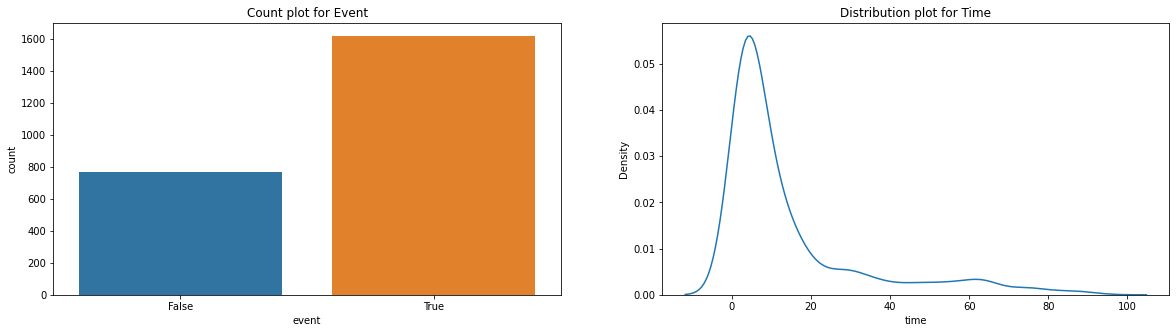

In [14]:
# plotting distribution of event
print("% of dropouts :", training_dataset.event.mean())

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))
sns.countplot(x = training_dataset.event, ax = ax1)
ax1.set_title("Count plot for Event")
sns.kdeplot(x = training_dataset.time, ax = ax2)
ax2.set_title("Distribution plot for Time")
plt.show();

#### Features

In [15]:
# creating variable set
id_col = ['Emp_ID']
target_cols = ['time', 'event']
cont_cols = ['Age', 'Avg_Salary', 'Total Business Value']
cat_cols = ['Gender', 'Salary_Increase', 'Designation', 'Promotion', 
            'Median_quarterly_rating', 'City_C10', 'City_C11', 'City_C12', 
            'City_C13', 'City_C14', 'City_C15', 'City_C16', 'City_C17', 'City_C18', 
            'City_C19', 'City_C2', 'City_C20', 'City_C21', 'City_C22', 'City_C23',
            'City_C24', 'City_C25', 'City_C26', 'City_C27', 'City_C28', 'City_C29',
            'City_C3', 'City_C4', 'City_C5', 'City_C6', 'City_C7', 'City_C8',
            'City_C9', 'Education_Level_College', 'Education_Level_Master']

##### Continuous features

In [16]:
# descriptive statistics
training_dataset[cont_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,"2,381.00",33.66,5.98,21.00,29.00,33.00,37.00,58.00
Avg_Salary,"2,381.00","59,232.46","28,298.21","10,747.00","39,104.00","55,285.00","75,835.00","188,418.00"
Total Business Value,"2,381.00","312,085.36","449,570.51","-197,932.86",0.00,"150,624.44","429,498.75","3,972,127.50"


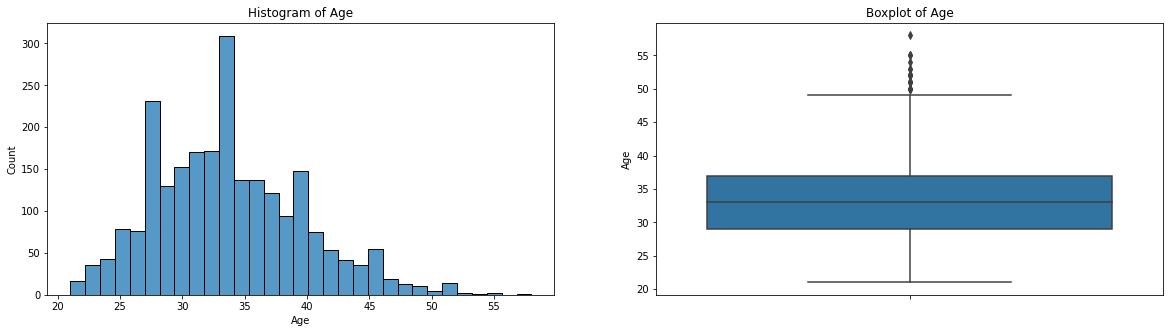

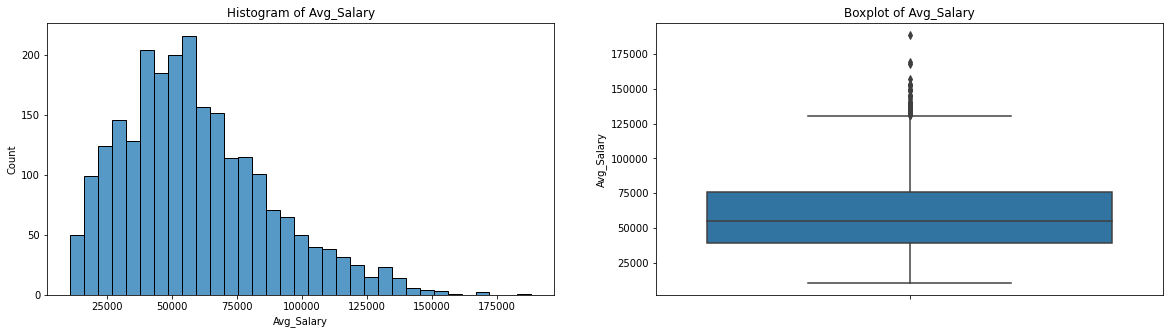

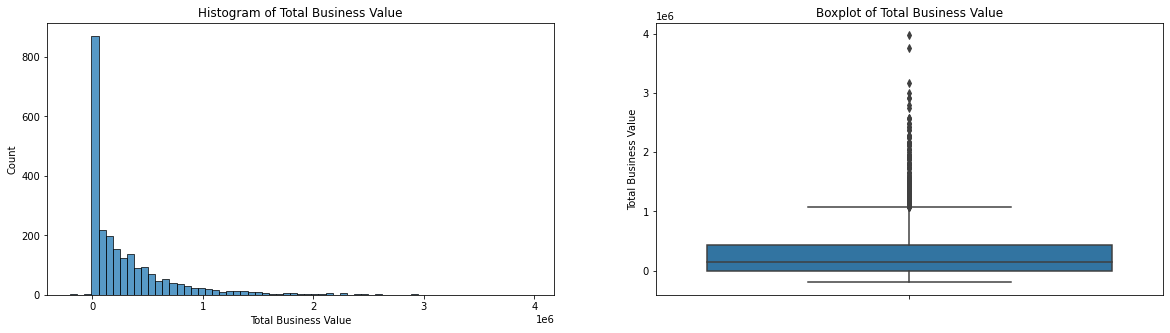

In [17]:
# distribution plot
for col in cont_cols:
  fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,5))
  sns.histplot(x = training_dataset[col], ax = ax1);
  ax1.set_title("Histogram of " + col)
  sns.boxplot(y = training_dataset[col], ax = ax2);
  ax2.set_title("Boxplot of " + col)
  plt.show()

##### Categorical features

Frequency analysis for :Gender
1   0.59
0   0.41
Name: Gender, dtype: float64


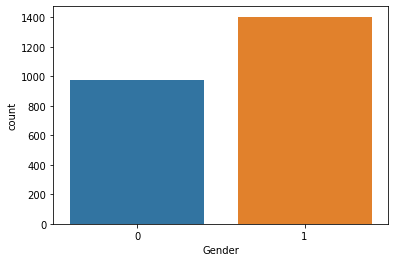

 
Frequency analysis for :Salary_Increase
0   0.98
1   0.02
Name: Salary_Increase, dtype: float64


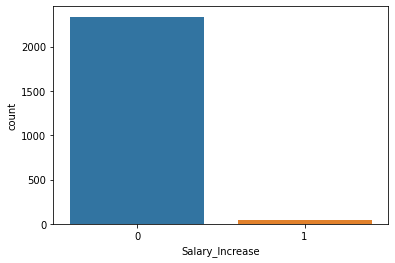

 
Frequency analysis for :Designation
2   0.36
1   0.31
3   0.26
4   0.06
5   0.01
Name: Designation, dtype: float64


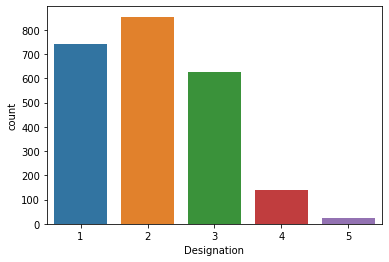

 
Frequency analysis for :Promotion
0   0.83
1   0.09
2   0.06
3   0.02
4   0.00
Name: Promotion, dtype: float64


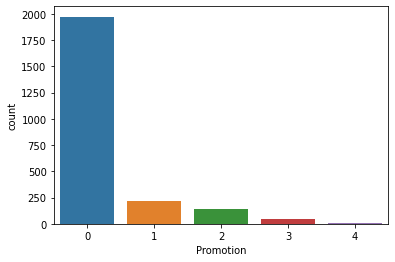

 
Frequency analysis for :Median_quarterly_rating
1.00   0.59
2.00   0.23
3.00   0.11
1.50   0.03
4.00   0.02
2.50   0.02
3.50   0.01
Name: Median_quarterly_rating, dtype: float64


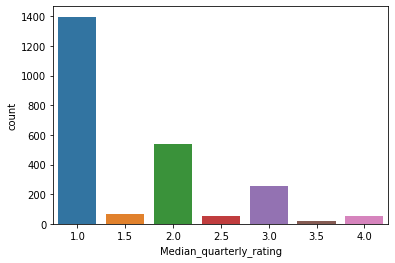

 
Frequency analysis for :City_C10
0   0.96
1   0.04
Name: City_C10, dtype: float64


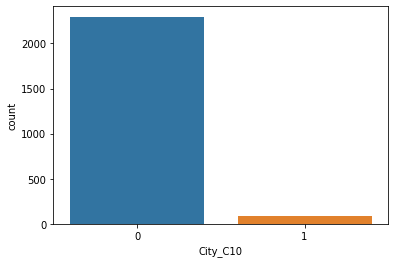

 
Frequency analysis for :City_C11
0   0.97
1   0.03
Name: City_C11, dtype: float64


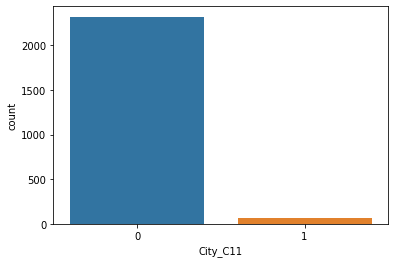

 
Frequency analysis for :City_C12
0   0.97
1   0.03
Name: City_C12, dtype: float64


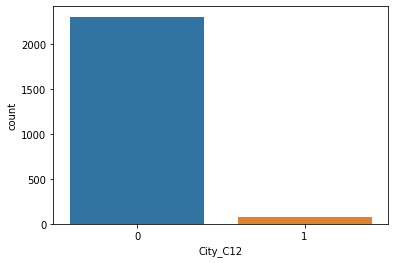

 
Frequency analysis for :City_C13
0   0.97
1   0.03
Name: City_C13, dtype: float64


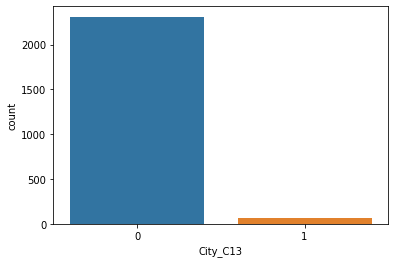

 
Frequency analysis for :City_C14
0   0.97
1   0.03
Name: City_C14, dtype: float64


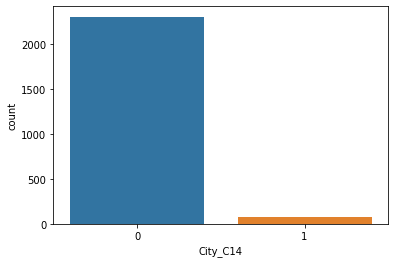

 
Frequency analysis for :City_C15
0   0.96
1   0.04
Name: City_C15, dtype: float64


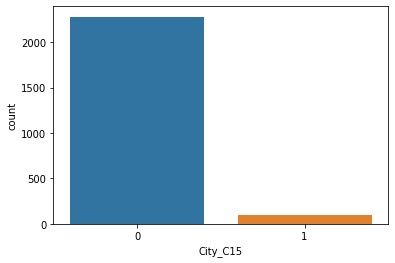

 
Frequency analysis for :City_C16
0   0.96
1   0.04
Name: City_C16, dtype: float64


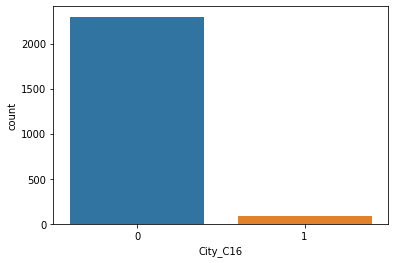

 
Frequency analysis for :City_C17
0   0.97
1   0.03
Name: City_C17, dtype: float64


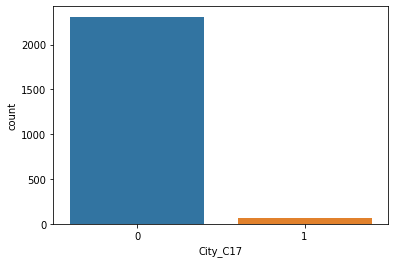

 
Frequency analysis for :City_C18
0   0.97
1   0.03
Name: City_C18, dtype: float64


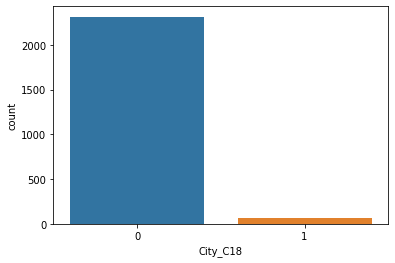

 
Frequency analysis for :City_C19
0   0.97
1   0.03
Name: City_C19, dtype: float64


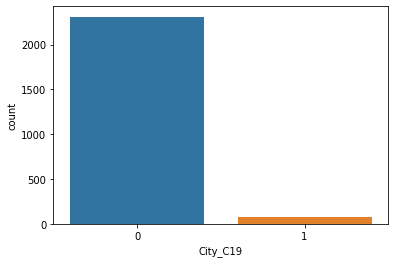

 
Frequency analysis for :City_C2
0   0.97
1   0.03
Name: City_C2, dtype: float64


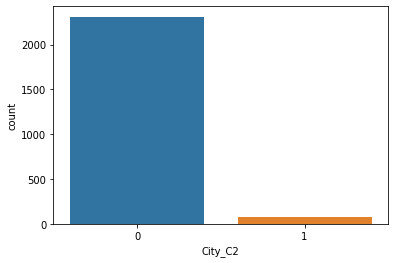

 
Frequency analysis for :City_C20
0   0.94
1   0.06
Name: City_C20, dtype: float64


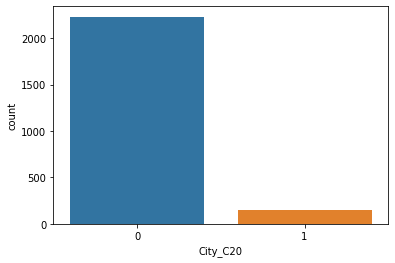

 
Frequency analysis for :City_C21
0   0.97
1   0.03
Name: City_C21, dtype: float64


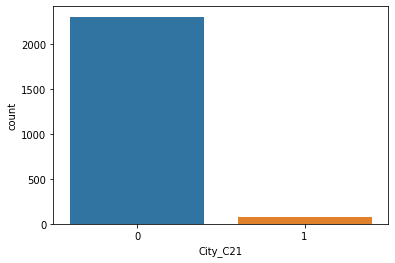

 
Frequency analysis for :City_C22
0   0.97
1   0.03
Name: City_C22, dtype: float64


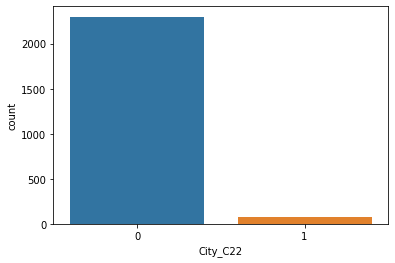

 
Frequency analysis for :City_C23
0   0.97
1   0.03
Name: City_C23, dtype: float64


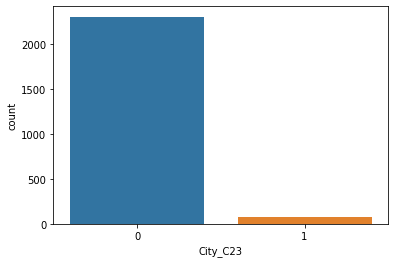

 
Frequency analysis for :City_C24
0   0.97
1   0.03
Name: City_C24, dtype: float64


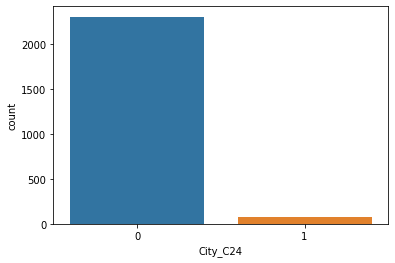

 
Frequency analysis for :City_C25
0   0.97
1   0.03
Name: City_C25, dtype: float64


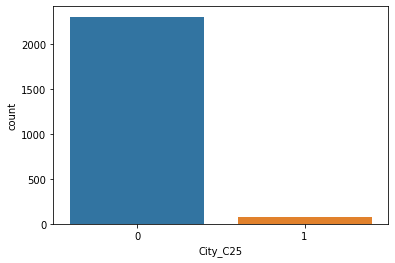

 
Frequency analysis for :City_C26
0   0.96
1   0.04
Name: City_C26, dtype: float64


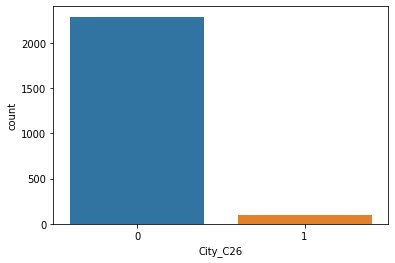

 
Frequency analysis for :City_C27
0   0.96
1   0.04
Name: City_C27, dtype: float64


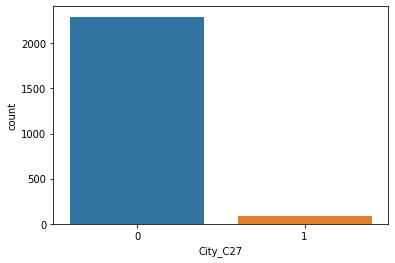

 
Frequency analysis for :City_C28
0   0.97
1   0.03
Name: City_C28, dtype: float64


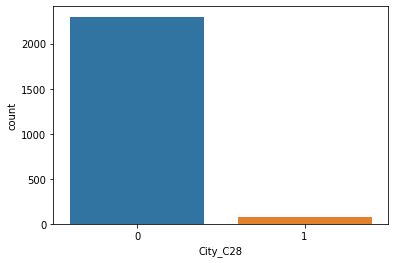

 
Frequency analysis for :City_C29
0   0.96
1   0.04
Name: City_C29, dtype: float64


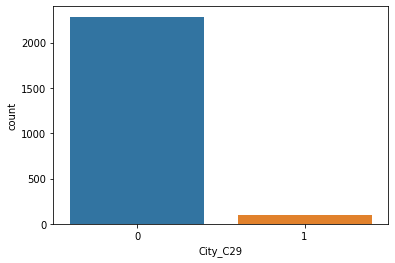

 
Frequency analysis for :City_C3
0   0.97
1   0.03
Name: City_C3, dtype: float64


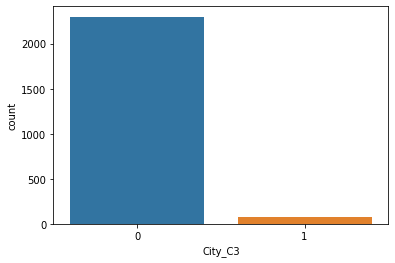

 
Frequency analysis for :City_C4
0   0.97
1   0.03
Name: City_C4, dtype: float64


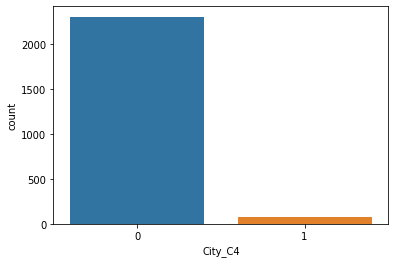

 
Frequency analysis for :City_C5
0   0.97
1   0.03
Name: City_C5, dtype: float64


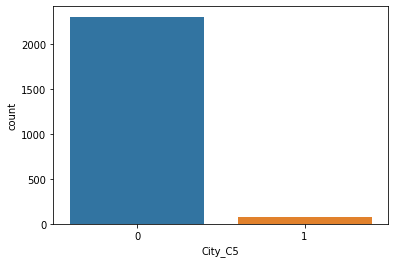

 
Frequency analysis for :City_C6
0   0.97
1   0.03
Name: City_C6, dtype: float64


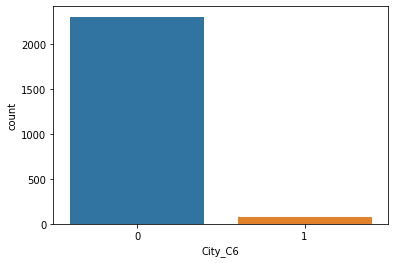

 
Frequency analysis for :City_C7
0   0.97
1   0.03
Name: City_C7, dtype: float64


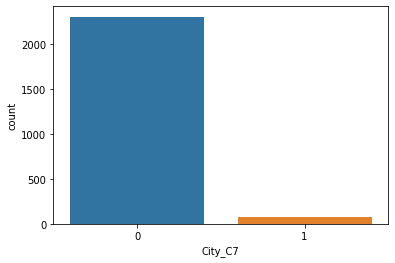

 
Frequency analysis for :City_C8
0   0.96
1   0.04
Name: City_C8, dtype: float64


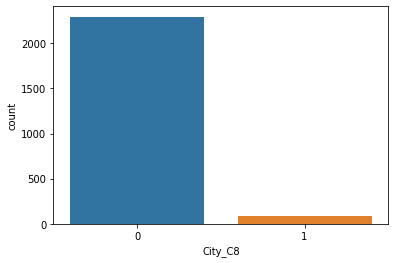

 
Frequency analysis for :City_C9
0   0.97
1   0.03
Name: City_C9, dtype: float64


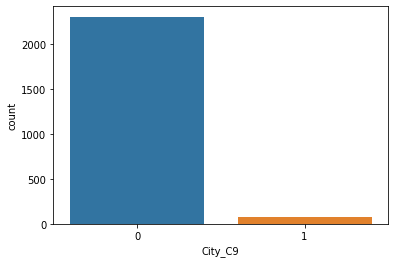

 
Frequency analysis for :Education_Level_College
0   0.67
1   0.33
Name: Education_Level_College, dtype: float64


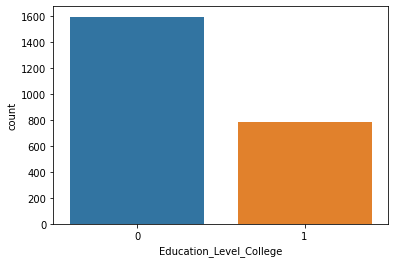

 
Frequency analysis for :Education_Level_Master
0   0.66
1   0.34
Name: Education_Level_Master, dtype: float64


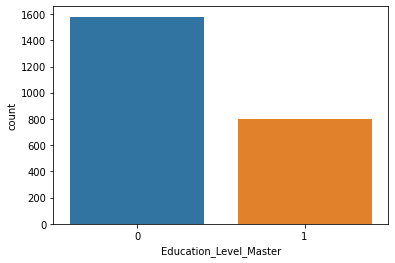

In [18]:
# feaquency analysis
for col in cat_cols:
  print("Frequency analysis for :" + col)
  print(training_dataset[col].value_counts(normalize = True))
  sns.countplot(x = training_dataset[col]);
  plt.show()
  print(" ")

### Bivariate analysis

#### Dropout Vs continuous features

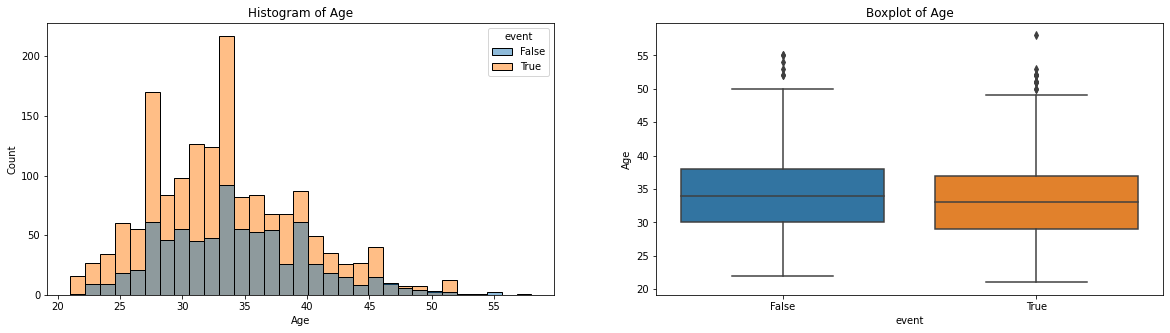

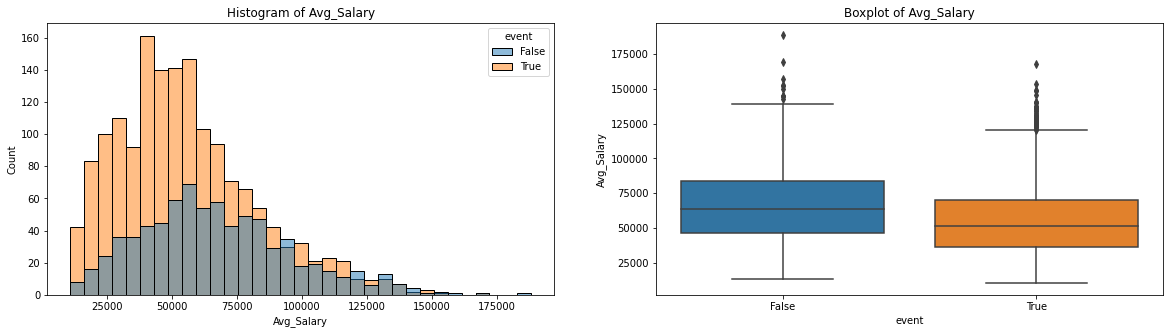

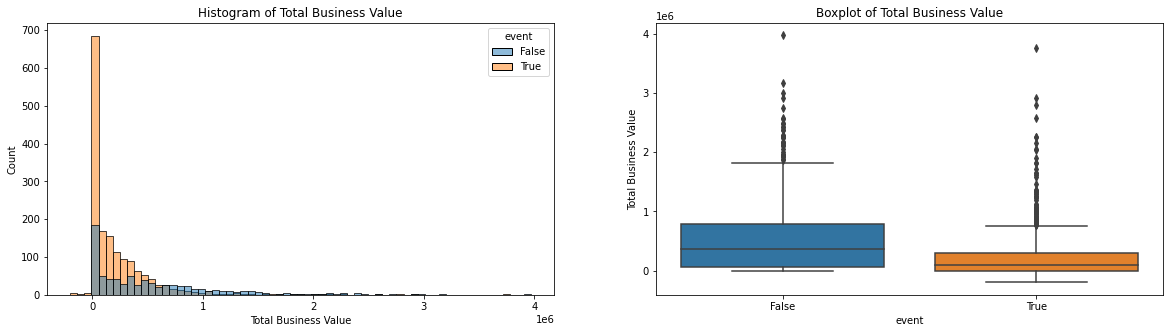

In [19]:
# bivariate analysis - histogram and boxplot
for col in cont_cols:
  fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,5))
  sns.histplot(x = training_dataset[col], ax = ax1, hue = training_dataset["event"]);
  ax1.set_title("Histogram of " + col)
  sns.boxplot(y = training_dataset[col], ax = ax2, x = training_dataset["event"]);
  ax2.set_title("Boxplot of " + col)
  plt.show()

#### Time to stay Vs Continuous features

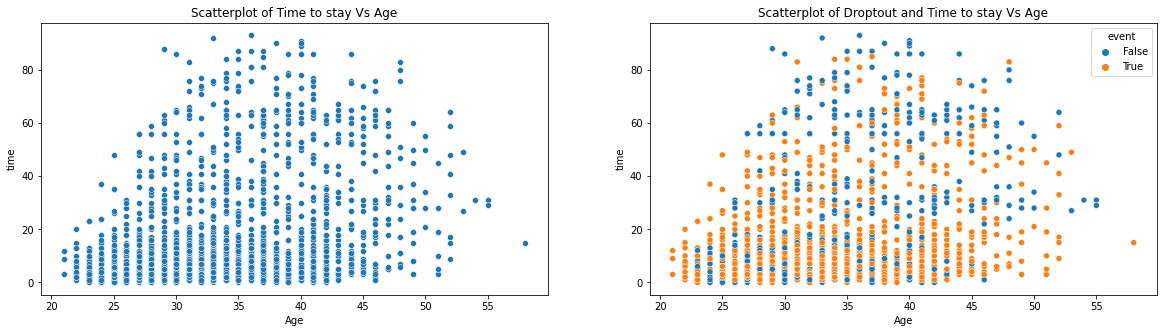

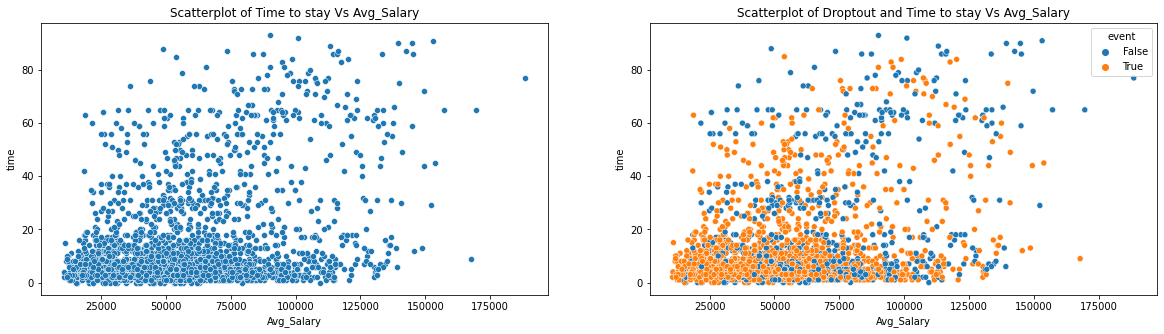

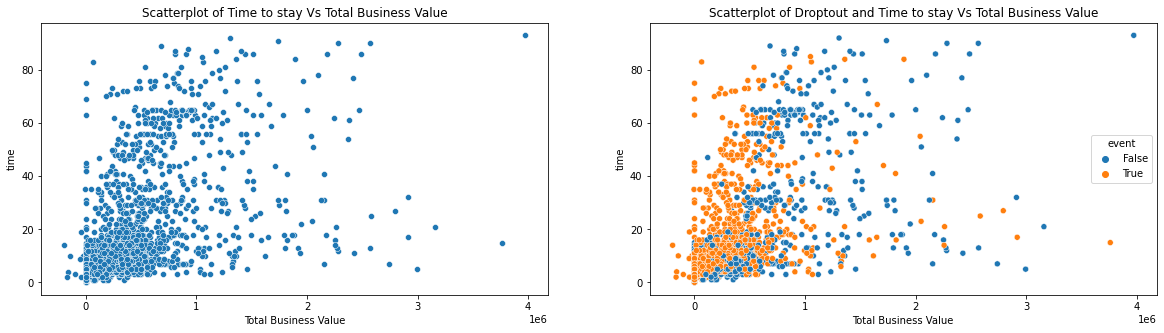

In [20]:
# bivariate analysis - histogram and boxplot
for col in cont_cols:
  fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,5))
  sns.scatterplot(x = training_dataset[col], y = training_dataset["time"], ax = ax1);
  ax1.set_title("Scatterplot of Time to stay Vs " + col)
  sns.scatterplot(x = training_dataset[col], 
                  y = training_dataset["time"], 
                  hue = training_dataset["event"], ax = ax2);
  ax2.set_title("Scatterplot of Droptout and Time to stay Vs " + col)
  plt.show()

#### Dropout Vs Categorical features

Bivariate plot for dropout Vs :Gender


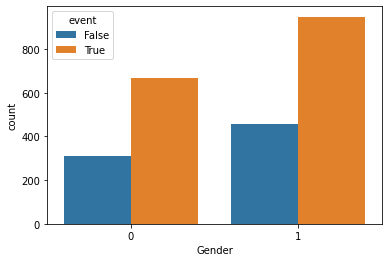

Bivariate plot for dropout Vs :Salary_Increase


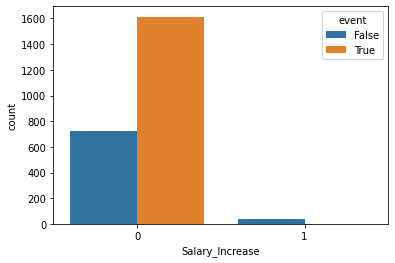

Bivariate plot for dropout Vs :Designation


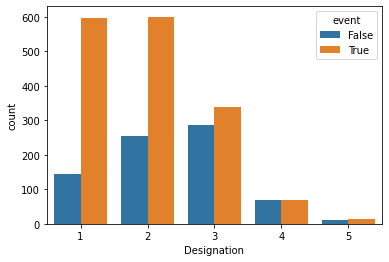

Bivariate plot for dropout Vs :Promotion


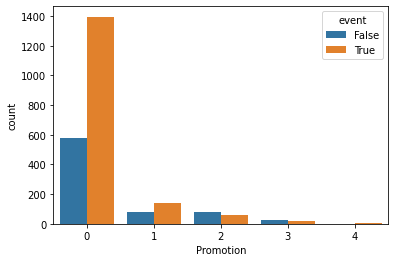

Bivariate plot for dropout Vs :Median_quarterly_rating


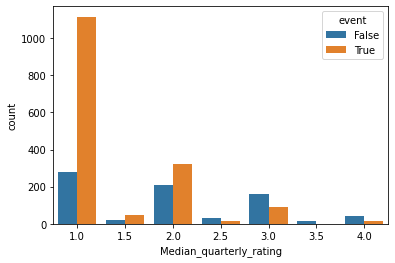

Bivariate plot for dropout Vs :City_C10


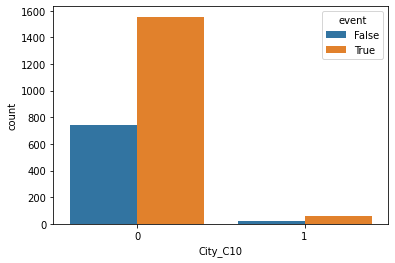

Bivariate plot for dropout Vs :City_C11


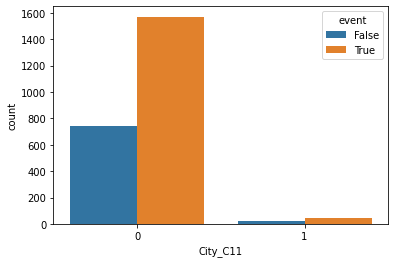

Bivariate plot for dropout Vs :City_C12


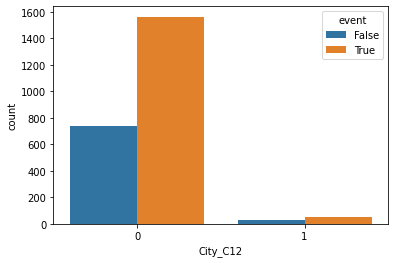

Bivariate plot for dropout Vs :City_C13


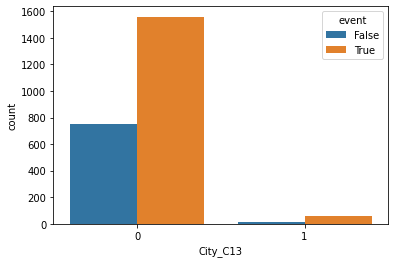

Bivariate plot for dropout Vs :City_C14


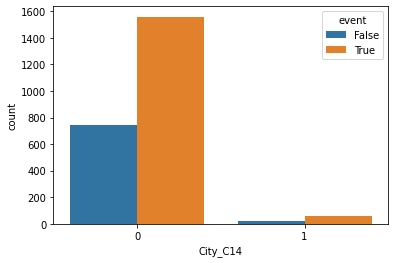

Bivariate plot for dropout Vs :City_C15


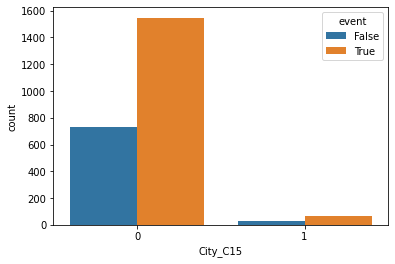

Bivariate plot for dropout Vs :City_C16


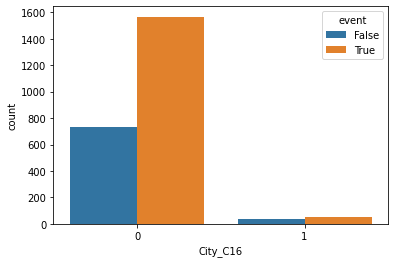

Bivariate plot for dropout Vs :City_C17


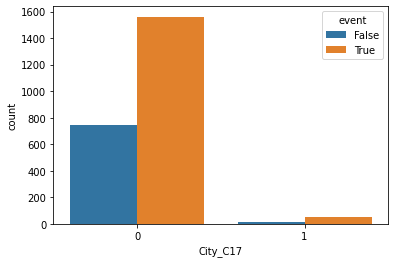

Bivariate plot for dropout Vs :City_C18


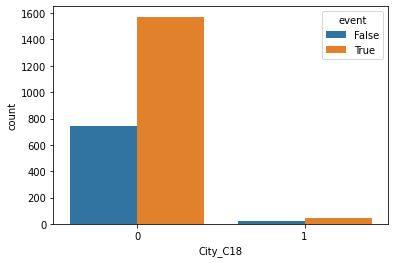

Bivariate plot for dropout Vs :City_C19


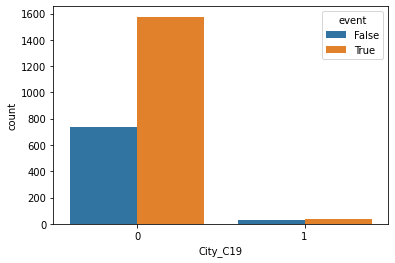

Bivariate plot for dropout Vs :City_C2


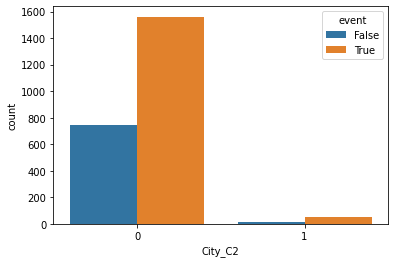

Bivariate plot for dropout Vs :City_C20


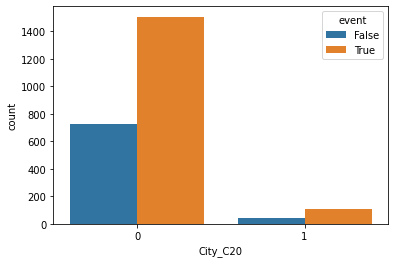

Bivariate plot for dropout Vs :City_C21


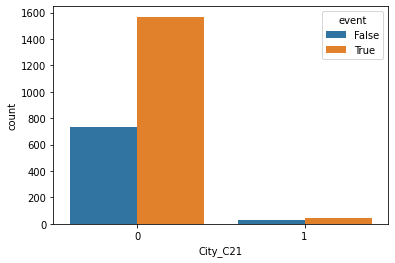

Bivariate plot for dropout Vs :City_C22


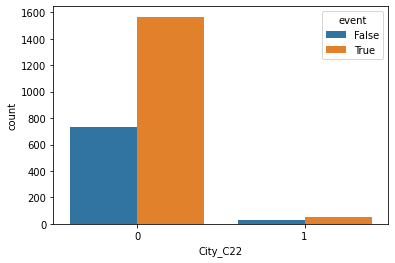

Bivariate plot for dropout Vs :City_C23


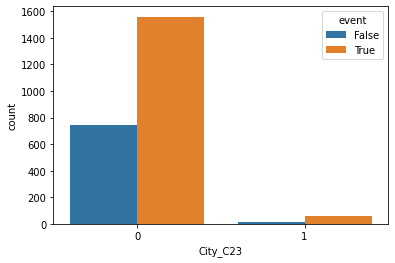

Bivariate plot for dropout Vs :City_C24


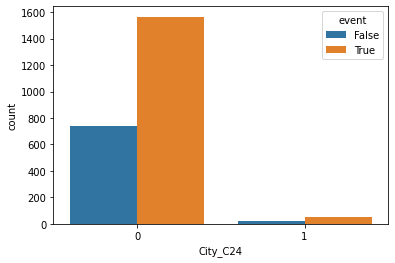

Bivariate plot for dropout Vs :City_C25


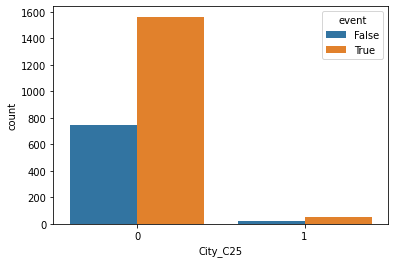

Bivariate plot for dropout Vs :City_C26


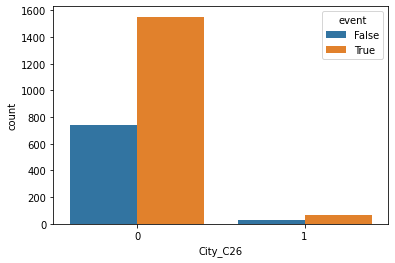

Bivariate plot for dropout Vs :City_C27


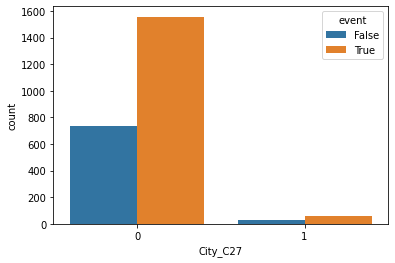

Bivariate plot for dropout Vs :City_C28


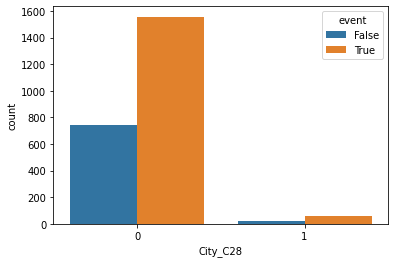

Bivariate plot for dropout Vs :City_C29


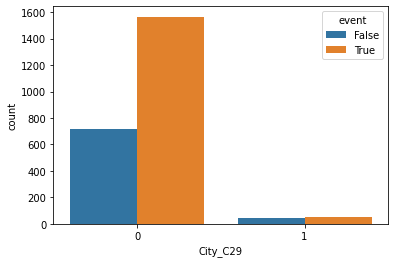

Bivariate plot for dropout Vs :City_C3


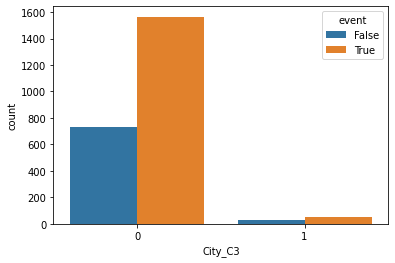

Bivariate plot for dropout Vs :City_C4


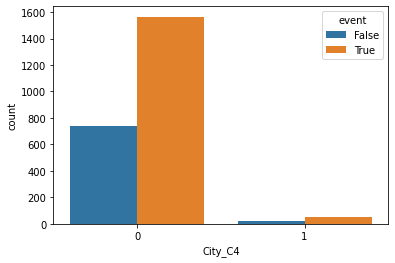

Bivariate plot for dropout Vs :City_C5


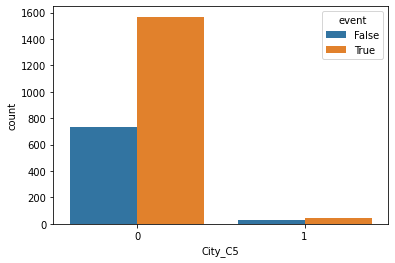

Bivariate plot for dropout Vs :City_C6


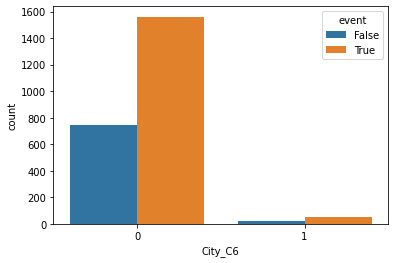

Bivariate plot for dropout Vs :City_C7


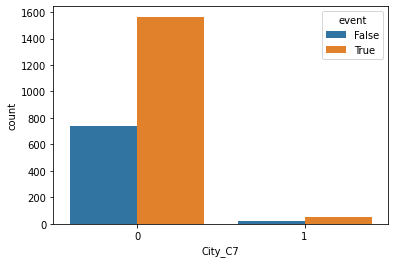

Bivariate plot for dropout Vs :City_C8


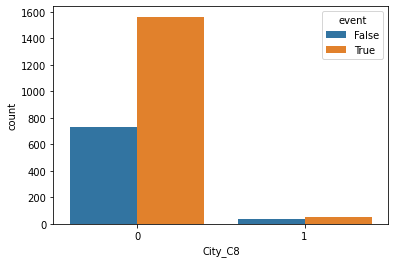

Bivariate plot for dropout Vs :City_C9


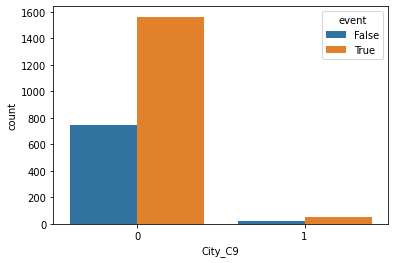

Bivariate plot for dropout Vs :Education_Level_College


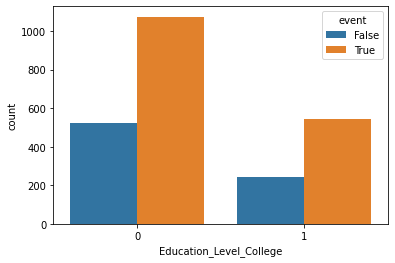

Bivariate plot for dropout Vs :Education_Level_Master


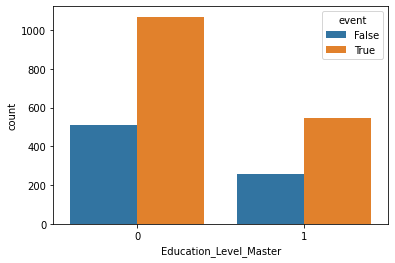

In [21]:
for col in cat_cols:
  print("Bivariate plot for dropout Vs :" + col)
  sns.countplot(x = training_dataset[col], hue = training_dataset["event"]);
  plt.show()

#### Time to stay Vs Categorical features

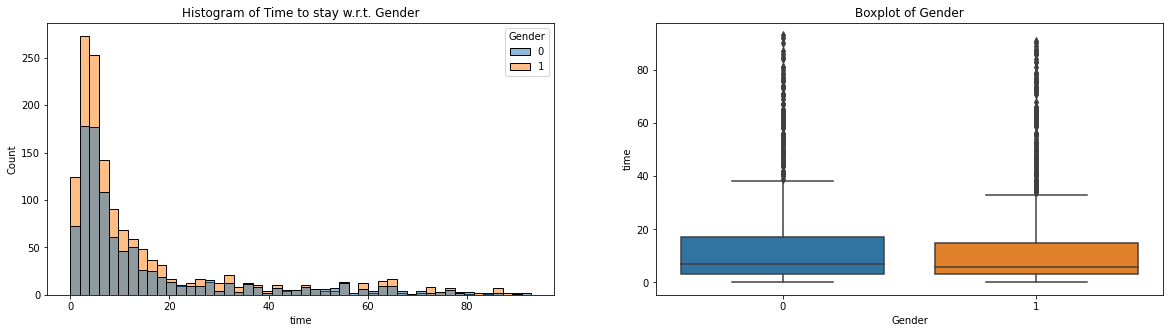

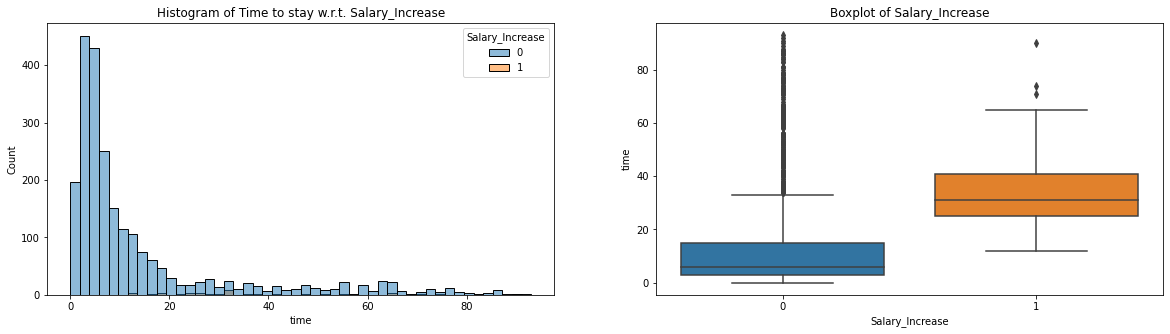

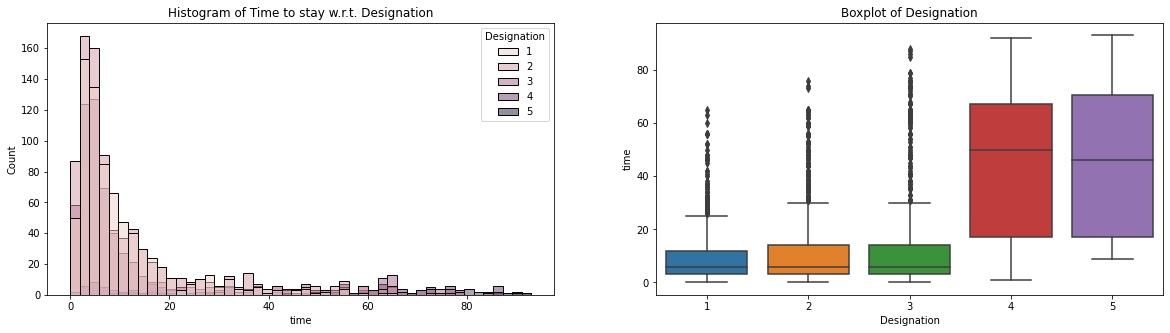

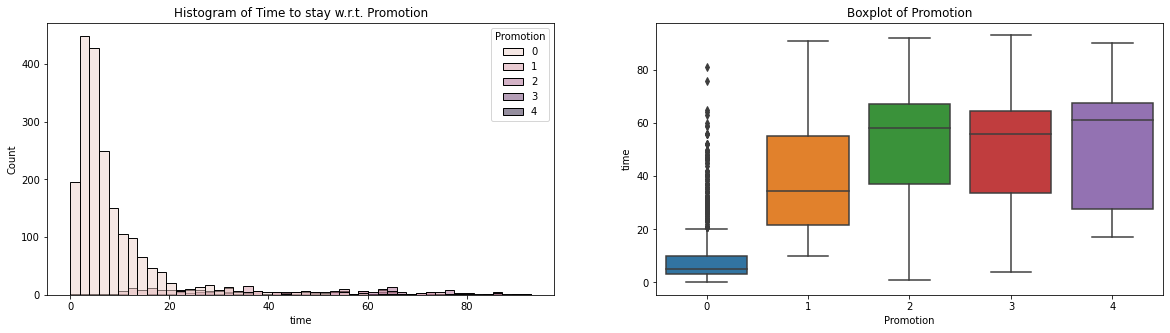

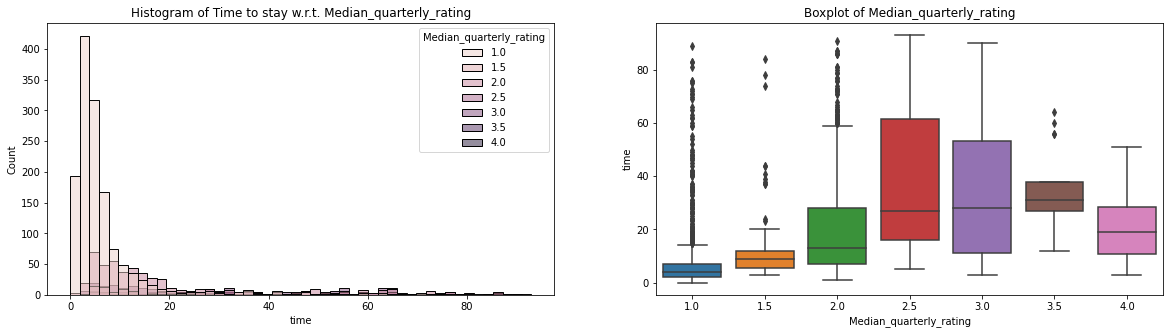

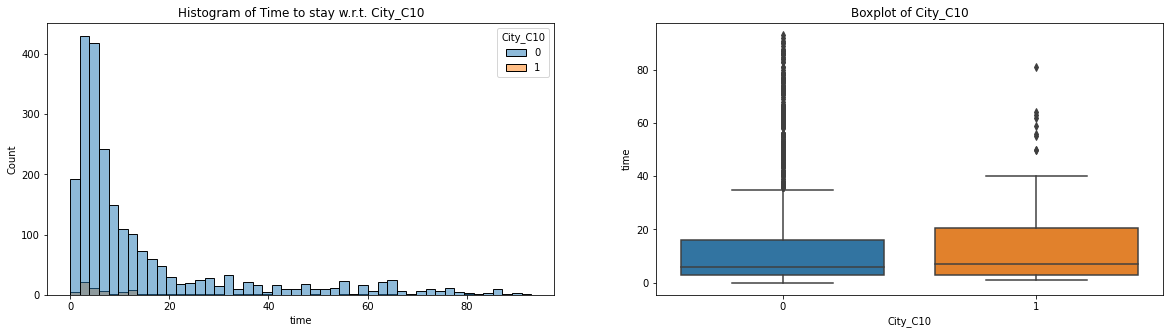

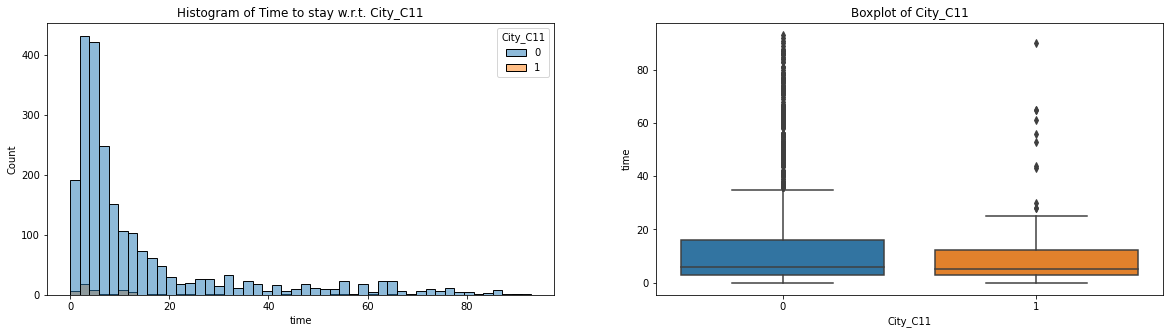

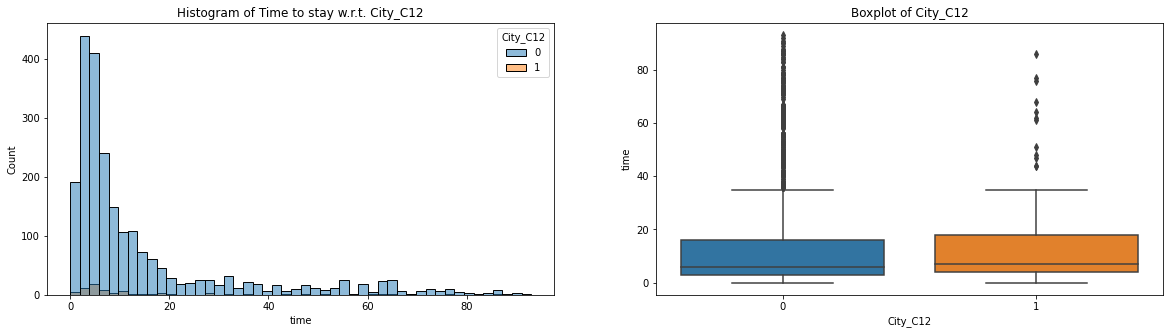

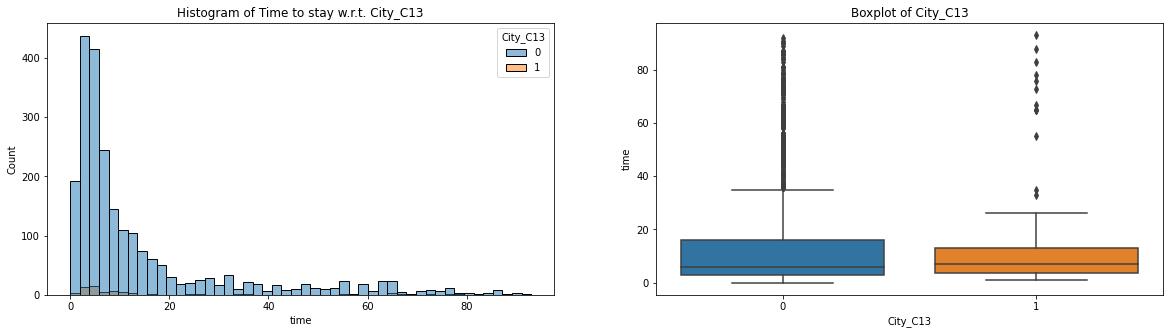

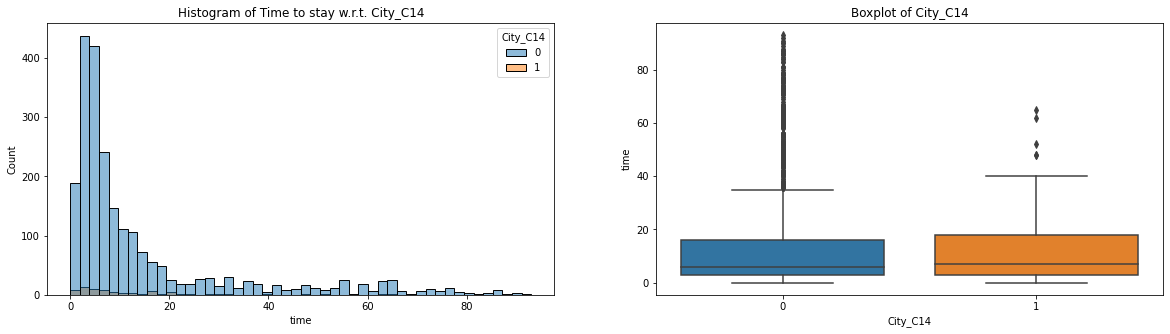

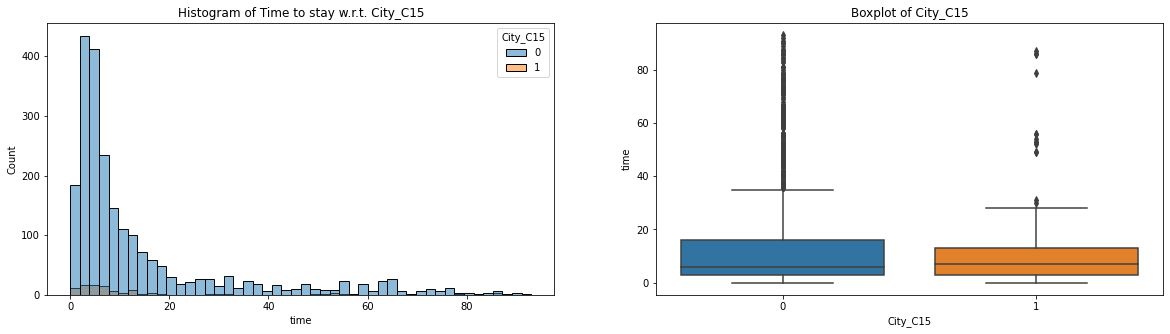

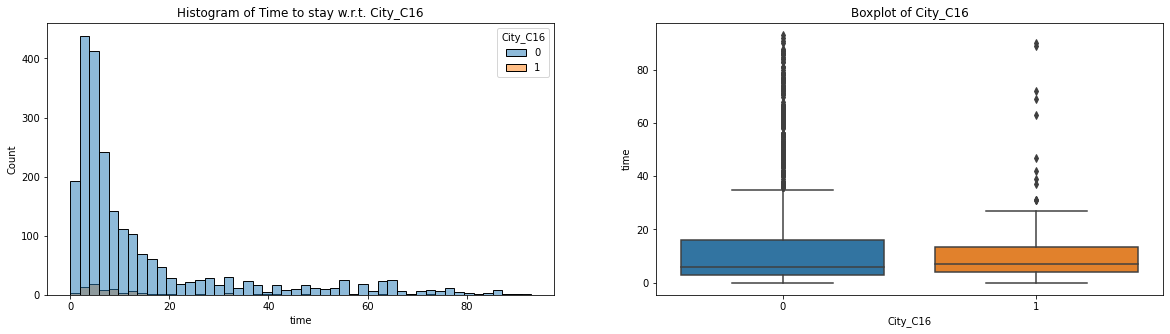

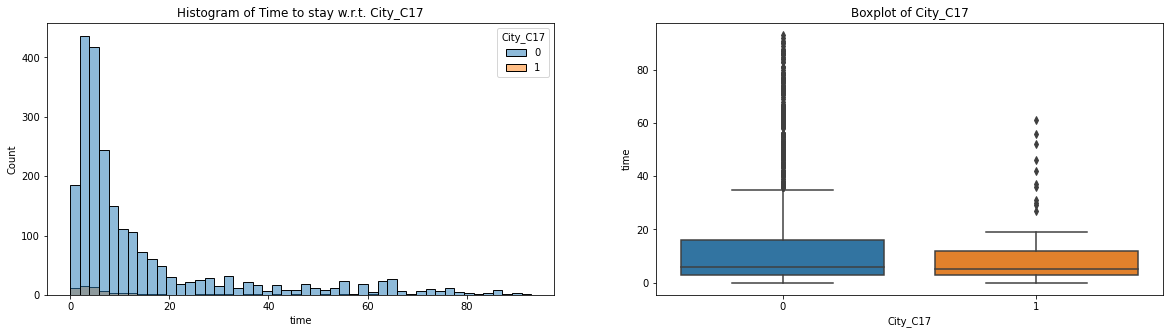

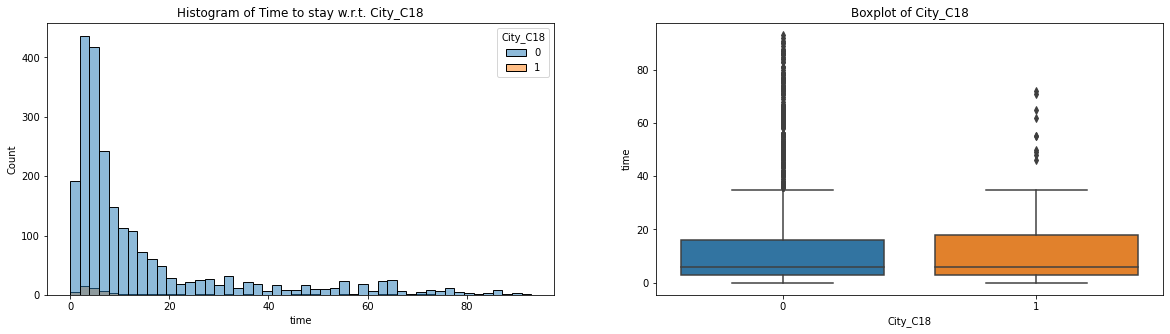

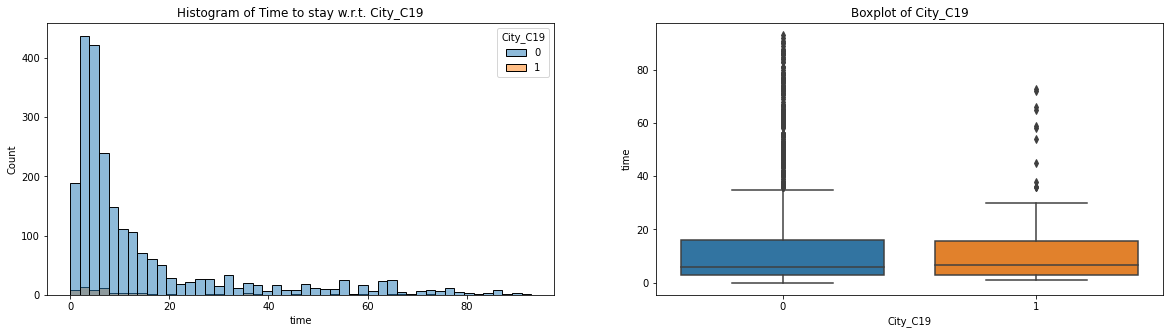

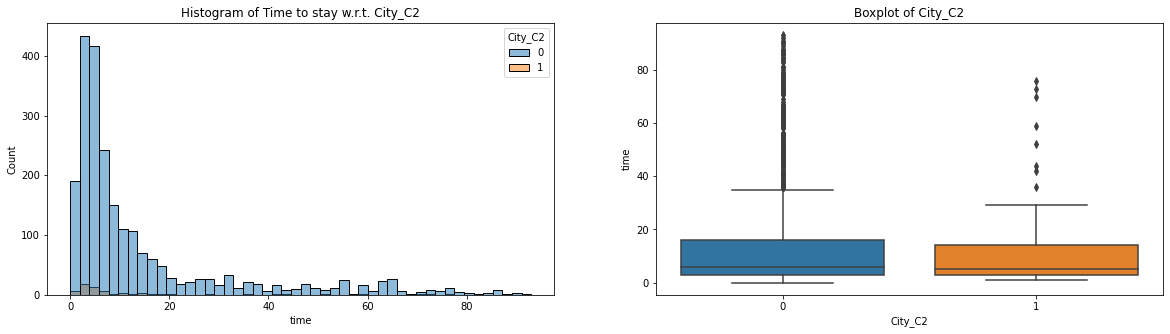

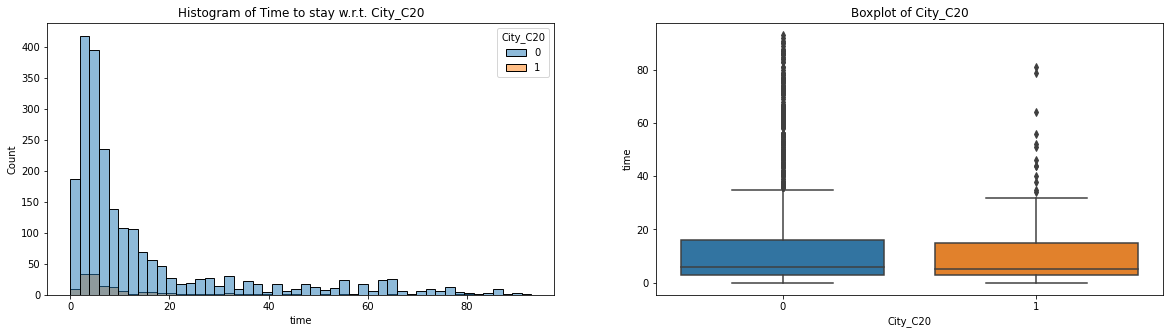

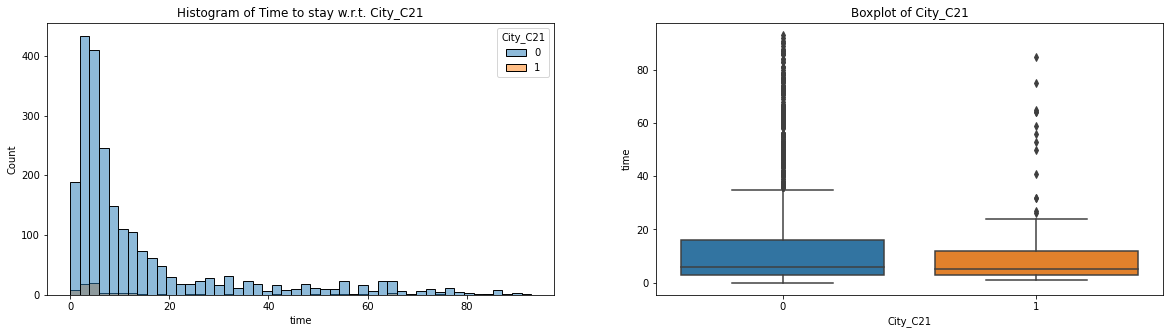

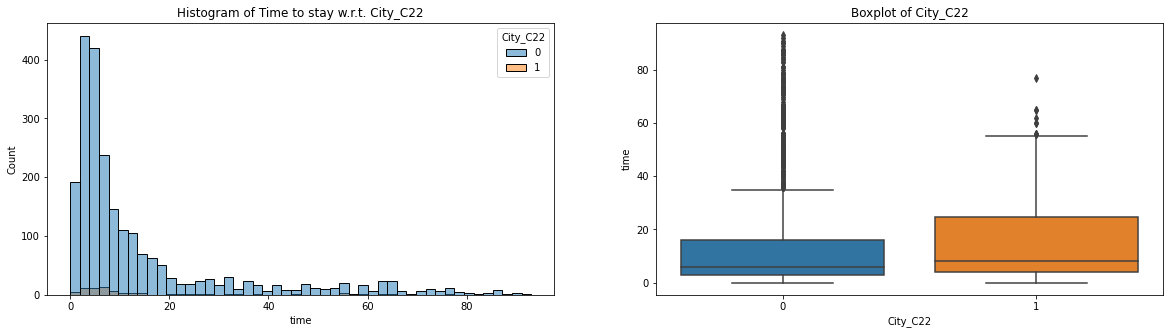

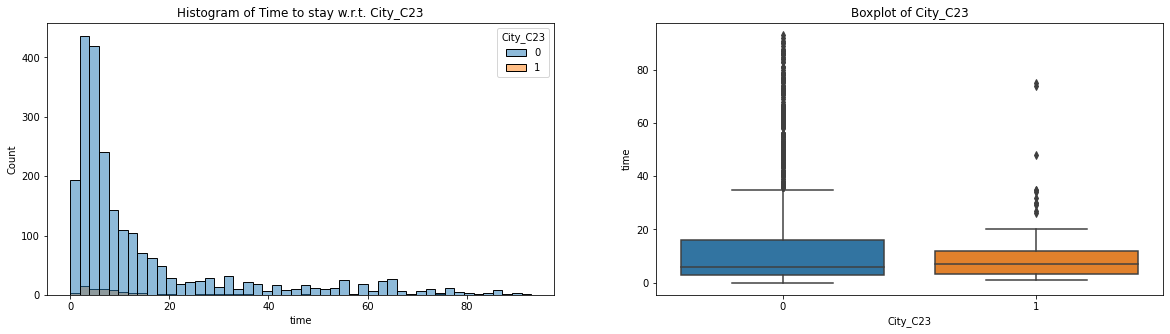

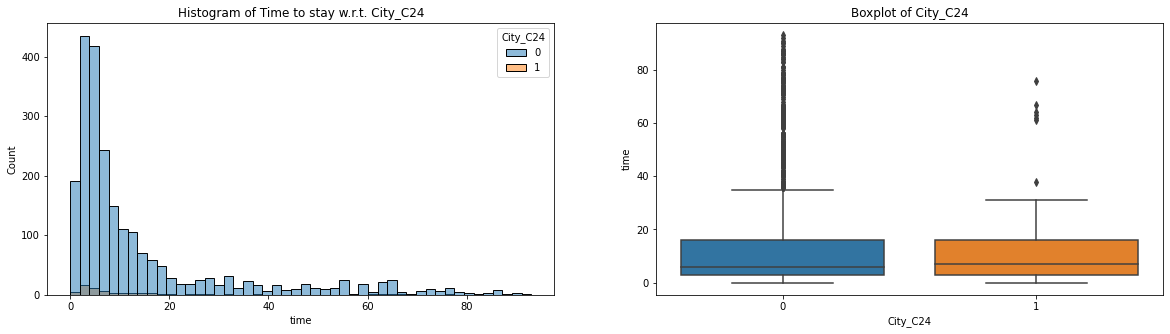

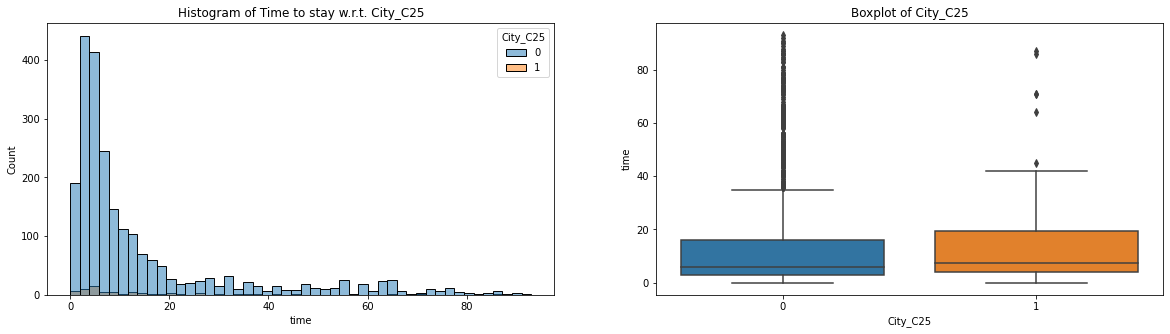

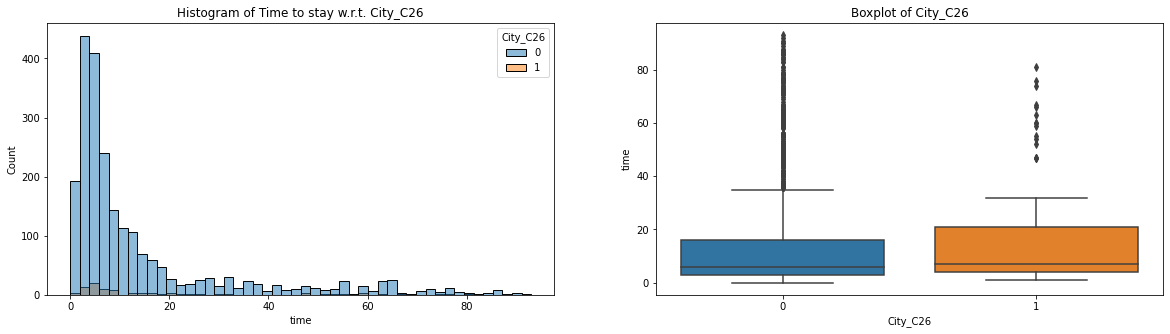

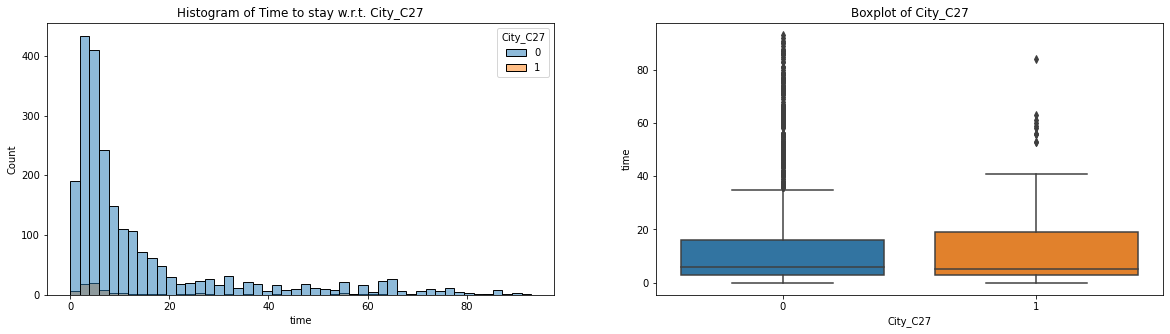

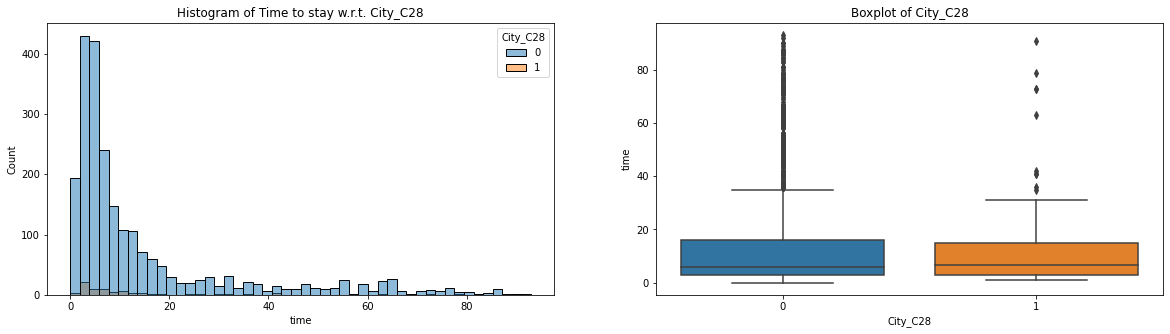

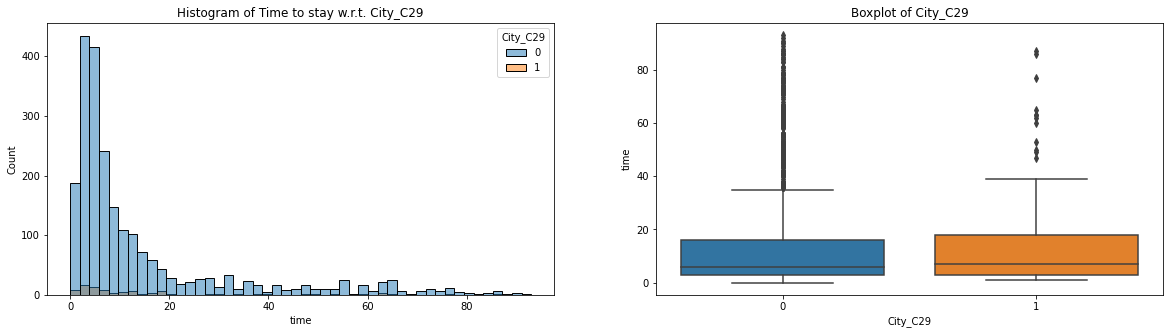

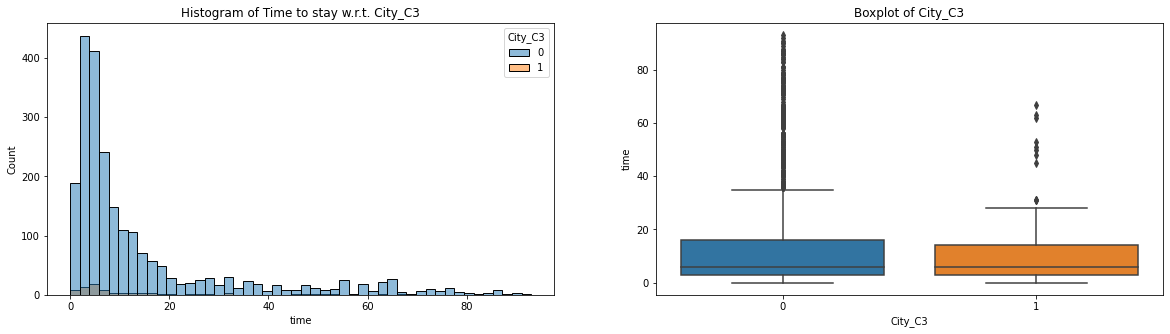

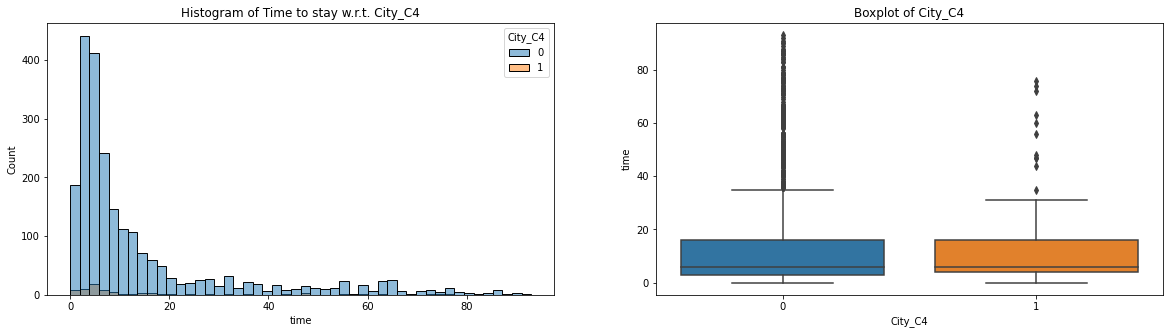

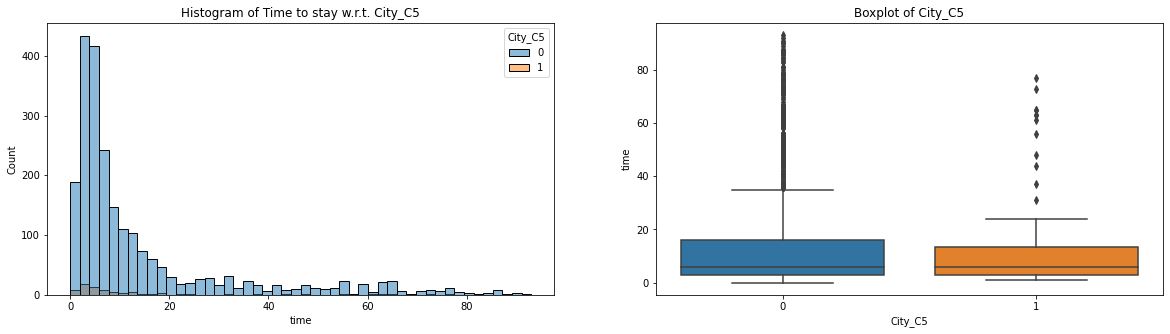

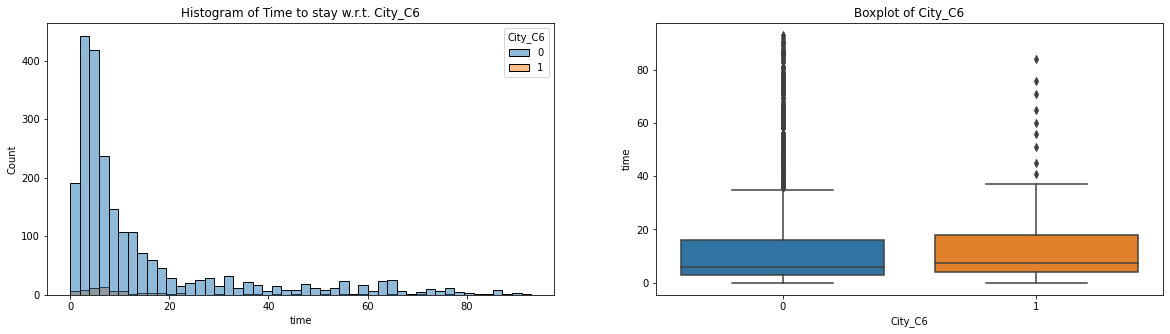

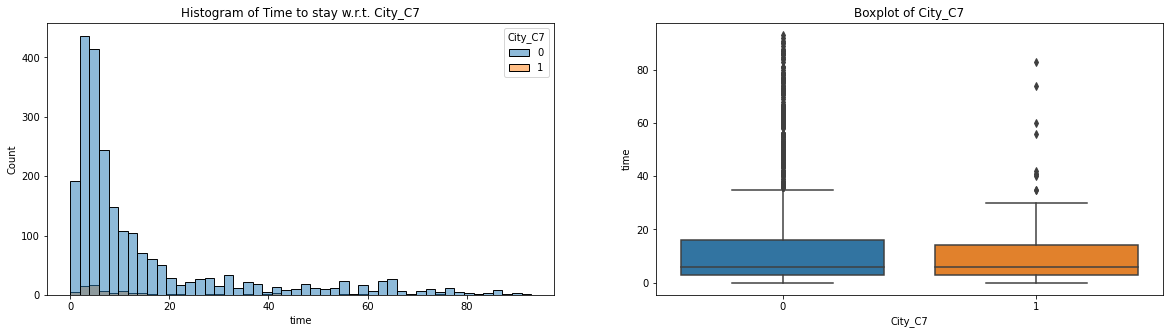

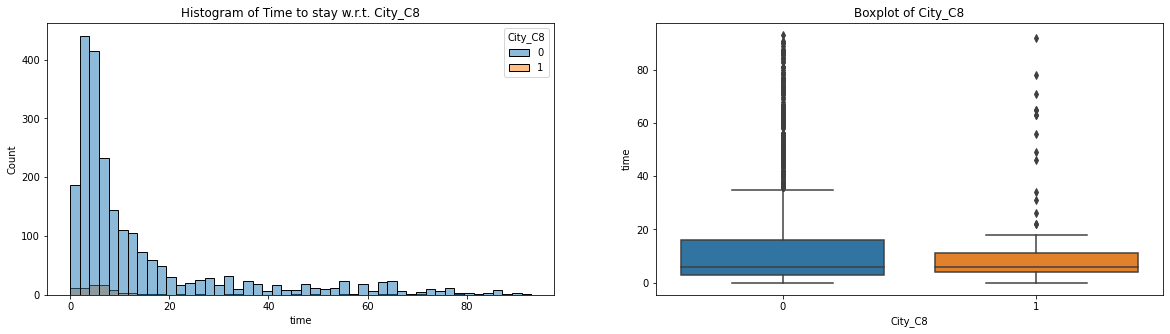

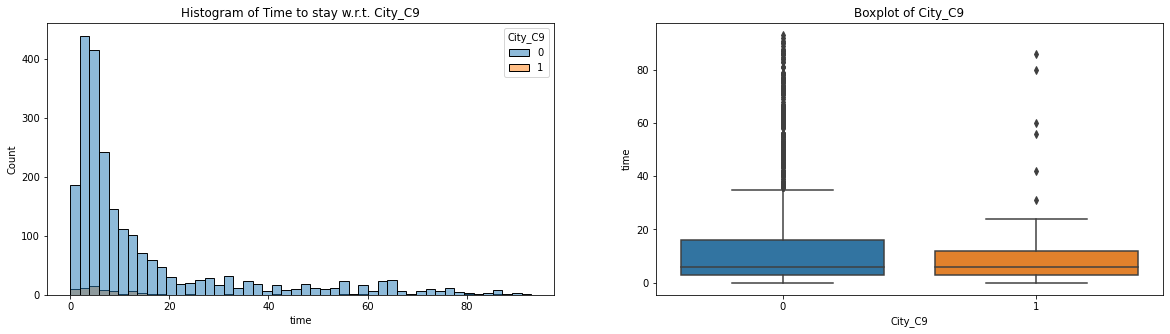

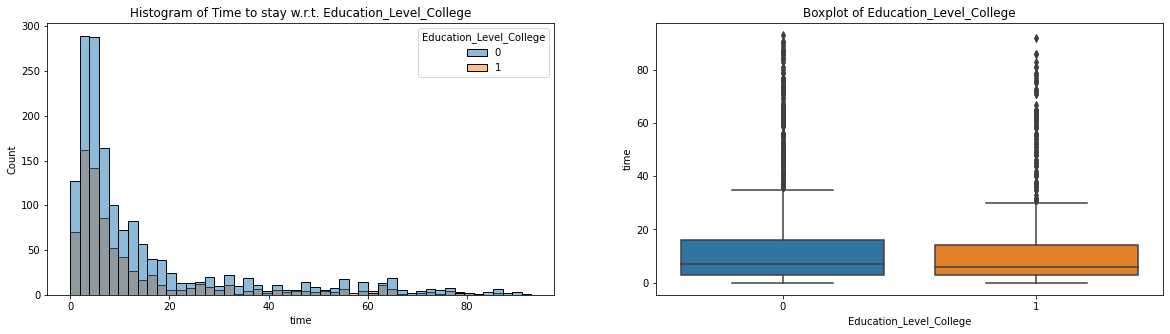

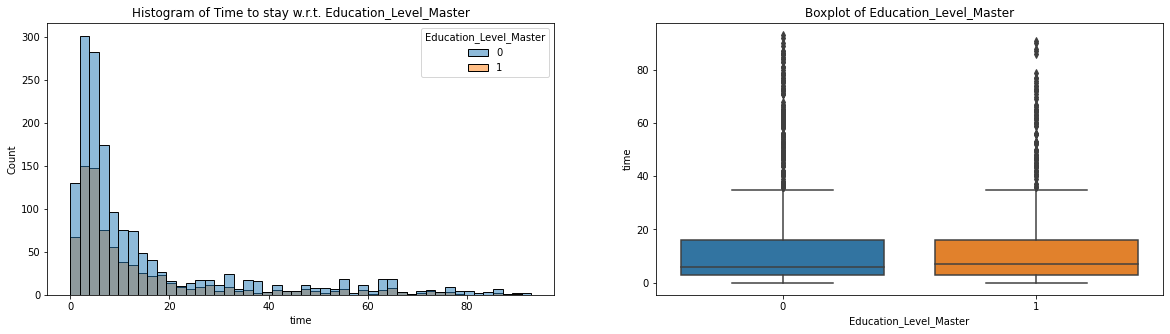

In [22]:
# bivariate analysis - histogram and boxplot
for col in cat_cols:
  fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,5))
  sns.histplot(x = training_dataset["time"], ax = ax1, hue = training_dataset[col]);
  ax1.set_title("Histogram of Time to stay w.r.t. " + col)
  sns.boxplot(y = training_dataset["time"], ax = ax2, x = training_dataset[col]);
  ax2.set_title("Boxplot of " + col)
  plt.show()

### Multivariate analysis

#### Correlation analysis

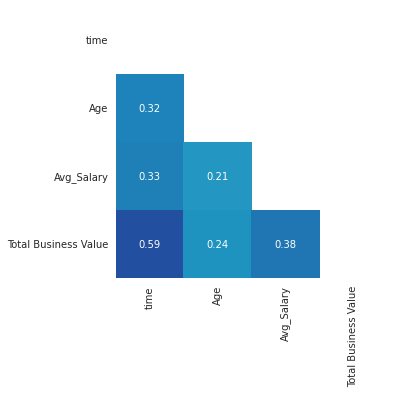

In [23]:
corr = training_dataset[["time", "Age", "Avg_Salary", "Total Business Value"]].corr().round(2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 5))
    ax = sns.heatmap(corr, mask=mask, annot = True, vmin = -1.0, vmax = 1.0, cbar = False, square=True, cmap="YlGnBu")

## **Survival Regression**

### Utility functions

In [24]:
# function for generating predicitons
def predict_survival(dataset, test_df, event_var, time_var, model, period, ID):
  
  # creating censored subjects data
  censored_subjects = dataset.loc[~dataset[event_var].astype(bool)]
  censored_subjects_last_obs = censored_subjects[time_var]

  # predicting survival probability and median survival period
  pred_df_cph = \
  model.predict_survival_function(censored_subjects, 
                                  conditional_after=censored_subjects_last_obs, 
                                  times = [period]).transpose()
  pred_df_cph["Median Remianing Survival"] = \
  model.predict_median(censored_subjects, conditional_after=censored_subjects_last_obs)
  pred_df_cph.columns = ["Survival Probability", "Median_Remianing_Survival"]
  pred_df_cph["Target"] = np.where(pred_df_cph["Median_Remianing_Survival"]<=period,1,0)
  pred_df_cph["Target"] = pred_df_cph["Target"].astype(int)
  output_df = dataset[[ID]]
  output_df = output_df.join(pred_df_cph)
  output_df = output_df.dropna()
  output_df = pd.merge(test_df, output_df, on = ID, how = "left")
  
  return output_df

### Splitting training data into train and validation for out of sample validation

In [25]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(training_dataset, test_size = 0.3, random_state = 123)

print("Shape of training data :", train_df.shape)
print("Shape of validation data :", val_df.shape)

Shape of training data : (1666, 41)
Shape of validation data : (715, 41)


### Cox’s proportional hazard model

<lifelines.CoxPHFitter: fitted with 1666 total observations, 530 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1666
number of events observed = 1136
   partial log-likelihood = -6856.78
         time fit was run = 2021-11-21 17:50:39 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
Gender                    0.02       1.02       0.06            -0.10             0.14                 0.91                 1.15
Age                      -0.02       0.98       0.01            -0.04            -0.01                 0.97                 0.99
Avg_Salary               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Salary_Increase           0.13       1.14       0.72            -1.29             1.54                 0.28                 4.68
Designation               0.02       1.02       0.05            -0.09             0.12                 0.92                 1.13
Promotion                -0.81       0.45       0.07            -0.95            -0.66                 0.39                 0.52
Total Business Value     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Median_quarterly_rating  -0.52       0.59       0.08            -0.68            -0.36                 0.51                 0.70
Education_Level_College   0.12       1.12       0.07            -0.03             0.26                 0.97                 1.30
Education_Level_Master    0.06       1.06       0.07            -0.09             0.21                 0.92                 1.23

                             z      p   -log2(p)
covariate                                       
Gender                    0.33   0.74       0.44
Age                      -4.56 <0.005      17.55
Avg_Salary               -1.69   0.09       3.46
Salary_Increase           0.18   0.86       0.22
Designation               0.31   0.75       0.41
Promotion               -10.88 <0.005      89.15
Total Business Value     -9.14 <0.005      63.76
Median_quarterly_rating  -6.43 <0.005      32.82
Education_Level_College   1.57   0.12       3.10
Education_Level_Master    0.82   0.41       1.27
---
Concordance = 0.83
Partial AIC = 13733.57
log-likelihood ratio test = 1188.33 on 10 df
-log2(p) of ll-ratio test = 824.92

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1666 total observations, 530 right-censored observations>
         test_name = proportional_hazard_test

---
                              test_statistic      p  -log2(p)
Age                     km              0.03   0.85      0.23
                        rank            0.09   0.77      0.38
Avg_Salary              km              0.69   0.41      1.30
                        rank            0.63   0.43      1.23
Designation             km             11.03 <0.005     10.12
                        rank           10.20 <0.005      9.47
Education_Level_College km              0.61   0.44      1.20
                        rank            0.71   0.40      1.32
Education_Level_Master  km              3.94   0.05      4.41
                        rank            4.06   0.04      4.51
Gender                  km              0.95   0.33      1.60
                        rank            0.74   0.39      1.36
Median_quarterly_rating km              5.32   0.02      5.57
                        rank            4.87   0.03      5.19
Promotion               km             19.49 <0.005     16.60
                        rank           14.96 <0.005     13.15
Salary_Increase         km              5.43   0.02      5.66
                        rank            4.45   0.03      4.84
Total Business Value    km            102.53 <0.005     77.64
                        rank          101.29 <0.005     76.74



1. Variable 'Designation' failed the non-proportional test: p-value is 0.0009.

   Advice: with so few unique values (only 5), you can include `strata=['Designation', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'Promotion' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 5), you can include `strata=['Promotion', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'Total Business Value' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'Total Business Value' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'T

[[<matplotlib.axes._subplots.AxesSubplot at 0x7f4445eef3d0>,

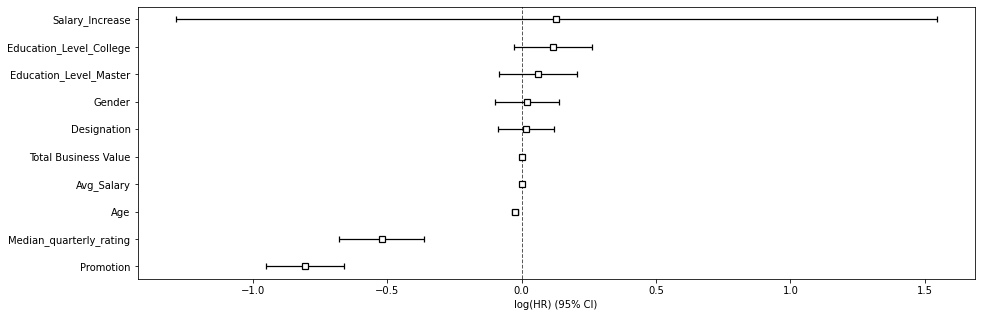

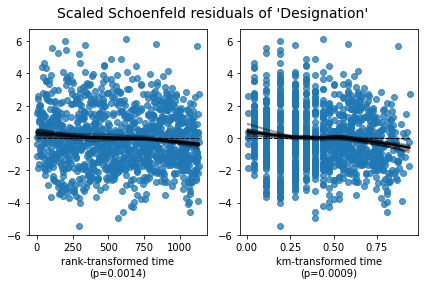

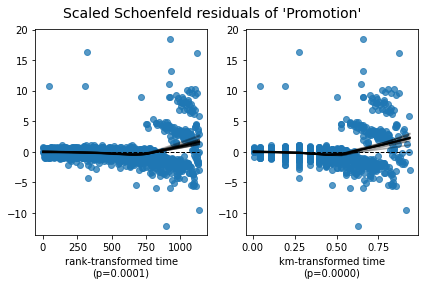

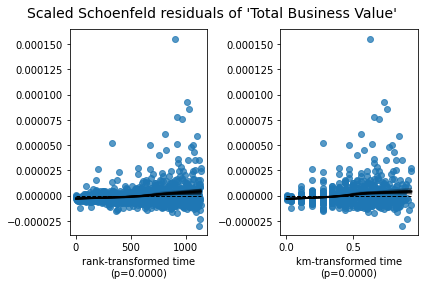

In [26]:
from lifelines import CoxPHFitter

# dropping some features
feature_set = ['Gender', 'Age', 'Avg_Salary',
               'Salary_Increase', 'Designation', 'Promotion', 'Total Business Value',
               'Median_quarterly_rating', 'Education_Level_College', 
               'Education_Level_Master']

train_df = train_df[feature_set + target_cols]

# fitting cox regression model
cph = CoxPHFitter()
cph.fit(train_df, duration_col='time', event_col='event')
cph.print_summary()

# plotting variables
plt.figure(figsize = (15,5))
cph.plot();

# checking assumptions
cph.check_assumptions(train_df, show_plots = True)

In [27]:
# checking model peformance metric
metric_all = pd.DataFrame()
metric_cox = \
pd.DataFrame({
    "model_name": "Cox Proptional Hazard",
    "train_log_likelihood": cph.log_likelihood_ ,
    "train_concordance_index":cph.score(train_df, scoring_method="concordance_index"),
    "val_log_likelihood":cph.score(val_df),
    "val_concordance_index":cph.score(val_df, scoring_method="concordance_index"),
    }, index = [0])

metric_all = metric_all.append(metric_cox)

### Weibull Accelerated failure time model

<lifelines.WeibullAFTFitter: fitted with 1666 total observations, 530 right-censored observations>
             duration col = 'time'
                event col = 'event'
   number of observations = 1666
number of events observed = 1136
           log-likelihood = -3783.97
         time fit was run = 2021-11-21 17:51:10 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                       
lambda_ Age                       0.02       1.02       0.00             0.01             0.02                 1.01                 1.02
        Avg_Salary                0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
        Designation              -0.07       0.93       0.04            -0.15             0.00                 0.86                 1.00
        Education_Level_College  -0.11       0.90       0.05            -0.21             0.00                 0.81                 1.00
        Education_Level_Master   -0.05       0.95       0.05            -0.16             0.06                 0.86                 1.06
        Gender                    0.01       1.01       0.04            -0.07             0.09                 0.93                 1.10
        Median_quarterly_rating   0.26       1.30       0.07             0.13             0.39                 1.14                 1.48
        Promotion                 0.67       1.96       0.06             0.56             0.79                 1.75                 2.20
        Salary_Increase           1.57       4.81       2.72            -3.76             6.90                 0.02               987.75
        Total Business Value      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
        Intercept                 0.97       2.64       0.15             0.68             1.26                 1.96                 3.54
rho_    Age                       0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
        Avg_Salary               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Designation              -0.04       0.96       0.04            -0.11             0.03                 0.89                 1.03
        Education_Level_College   0.11       1.11       0.05             0.00             0.21                 1.00                 1.23
        Education_Level_Master    0.08       1.09       0.05            -0.01             0.18                 0.99                 1.20
        Gender                   -0.15       0.86       0.04            -0.23            -0.06                 0.79                 0.94
        Median_quarterly_rating   0.09       1.09       0.05            -0.01             0.19                 0.99                 1.21
        Promotion                -0.03       0.98       0.05            -0.11             0.06                 0.89                 1.07
        Salary_Increase          -0.31       0.74       0.58            -1.44             0.83                 0.24                 2.29
        Total Business Value     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
        Intercept                 0.39       1.48       0.14             0.12             0.66                 1.13                 1.93

                                    z      p   -log2(p)
param   covariate                                      
lambda_ Age                      4.37 <0.005      16.30
        Avg_Salary               2.19   0.03       5.13
        Designation             -1.87   0.06       4.02
        Education_Level_College -1.94   0.05       4.27
        Education_Level_Master  -0.89   0.37 

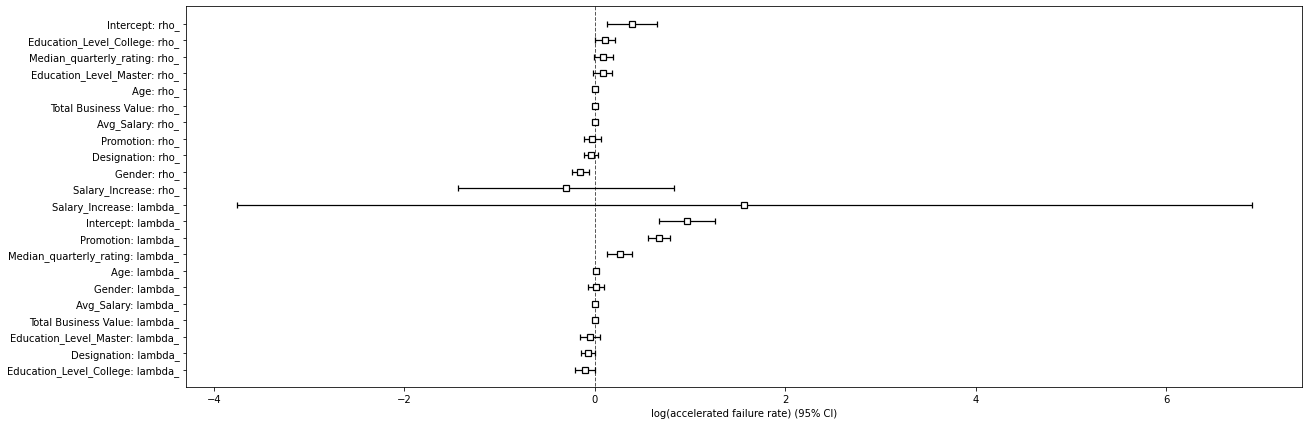

In [28]:
from lifelines import WeibullAFTFitter

# imputing 0 with small quantities
train_df_v2 = train_df.copy()
train_df_v2["time"] = np.where(train_df_v2["time"] == 0, 0.01, train_df_v2["time"])

aft = WeibullAFTFitter()
aft.fit(train_df_v2, duration_col='time', event_col='event', ancillary=True)

aft.print_summary()

plt.figure(figsize = (20,7))
aft.plot();

In [29]:
# checking model peformance metric
val_df_v2 = val_df.copy() 
val_df_v2["time"] = np.where(val_df_v2["time"] == 0.0, 0.01, val_df_v2["time"])

metric_waft = \
pd.DataFrame({
    "model_name": "Weibull Accerlated Failure time",
    "train_log_likelihood": aft.log_likelihood_ ,
    "train_concordance_index":aft.score(train_df, scoring_method="concordance_index"),
    "val_log_likelihood":aft.score(val_df_v2),
    "val_concordance_index":aft.score(val_df_v2, scoring_method="concordance_index"),
    }, index = [1])

metric_all = metric_all.append(metric_waft)

### Log Logistic Accelerated Failure Time model

<lifelines.LogLogisticAFTFitter: fitted with 1666 total observations, 530 right-censored observations>
             duration col = 'time'
                event col = 'event'
   number of observations = 1666
number of events observed = 1136
           log-likelihood = -3784.25
         time fit was run = 2021-11-21 17:51:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                       
alpha_ Age                       0.02       1.02       0.00             0.01             0.03                 1.01                 1.03
       Avg_Salary                0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Designation              -0.08       0.93       0.04            -0.15            -0.00                 0.86                 1.00
       Education_Level_College  -0.07       0.93       0.05            -0.17             0.04                 0.84                 1.04
       Education_Level_Master   -0.02       0.98       0.05            -0.13             0.08                 0.88                 1.09
       Gender                   -0.07       0.93       0.04            -0.15             0.02                 0.86                 1.02
       Median_quarterly_rating   0.43       1.54       0.06             0.32             0.55                 1.38                 1.72
       Promotion                 0.68       1.98       0.05             0.58             0.78                 1.79                 2.19
       Salary_Increase          -0.24       0.79       0.40            -1.02             0.54                 0.36                 1.72
       Total Business Value      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
       Intercept                 0.52       1.68       0.15             0.22             0.82                 1.25                 2.28
beta_  Intercept                 0.77       2.16       0.02             0.72             0.82                 2.06                 2.27

                                   z      p   -log2(p)
param  covariate                                      
alpha_ Age                      5.57 <0.005      25.26
       Avg_Salary               1.33   0.18       2.45
       Designation             -2.04   0.04       4.61
       Education_Level_College -1.27   0.20       2.29
       Education_Level_Master  -0.38   0.71       0.50
       Gender                  -1.55   0.12       3.04
       Median_quarterly_rating  7.61 <0.005      45.11
       Promotion               13.50 <0.005     135.62
       Salary_Increase         -0.60   0.55       0.86
       Total Business Value     8.38 <0.005      54.08
       Intercept                3.39 <0.005      10.51
beta_  Intercept               31.29 <0.005     711.32
---
Concordance = 0.83
AIC = 7592.49
log-likelihood ratio test = 1295.44 on 10 df
-log2(p) of ll-ratio test = 901.68

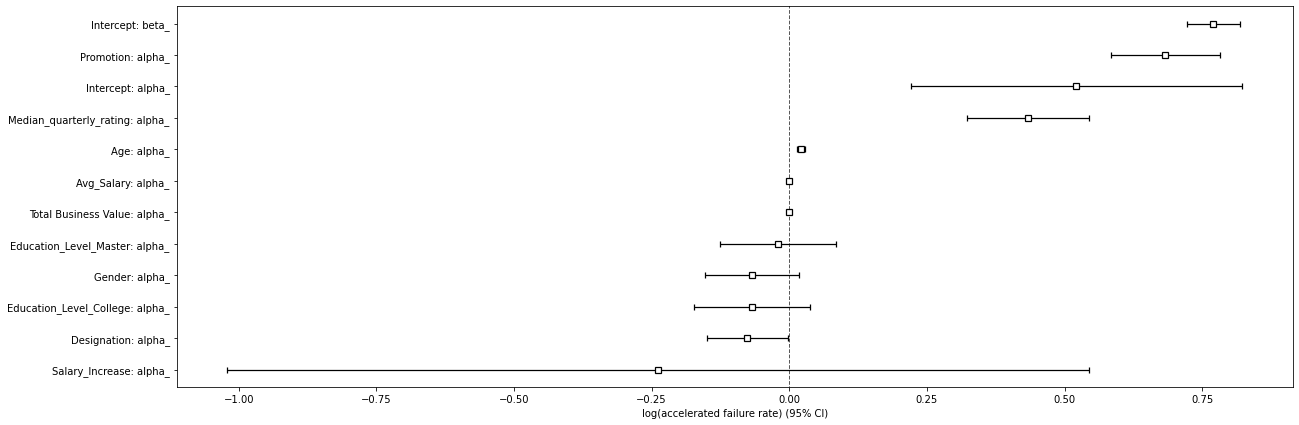

In [30]:
from lifelines import LogLogisticAFTFitter

llf = LogLogisticAFTFitter()
llf.fit(train_df_v2, 'time', 'event')

llf.print_summary()

plt.figure(figsize = (20,7))
llf.plot();

In [31]:
# checking model peformance metric
metric_llf = \
pd.DataFrame({
    "model_name": "Log Logistic Accerlated Failure time",
    "train_log_likelihood": llf.log_likelihood_ ,
    "train_concordance_index":llf.score(train_df_v2, scoring_method="concordance_index"),
    "val_log_likelihood":llf.score(val_df_v2),
    "val_concordance_index":llf.score(val_df_v2, scoring_method="concordance_index"),
    }, index = [2])

metric_all = metric_all.append(metric_llf)

### Log normal AFT model

<lifelines.LogNormalAFTFitter: fitted with 1666 total observations, 530 right-censored observations>
             duration col = 'time'
                event col = 'event'
   number of observations = 1666
number of events observed = 1136
           log-likelihood = -3928.04
         time fit was run = 2021-11-21 17:51:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                       
mu_    Age                       0.02       1.02       0.00             0.01             0.03                 1.01                 1.03
       Avg_Salary                0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       Designation              -0.05       0.95       0.05            -0.14             0.03                 0.87                 1.04
       Education_Level_College  -0.07       0.93       0.06            -0.19             0.06                 0.82                 1.06
       Education_Level_Master   -0.03       0.97       0.06            -0.15             0.10                 0.86                 1.10
       Gender                   -0.07       0.94       0.05            -0.17             0.04                 0.84                 1.04
       Median_quarterly_rating   0.62       1.85       0.06             0.50             0.74                 1.64                 2.09
       Promotion                 0.64       1.89       0.06             0.53             0.74                 1.70                 2.10
       Salary_Increase          -0.38       0.68       0.33            -1.03             0.27                 0.36                 1.31
       Total Business Value      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
       Intercept                 0.23       1.26       0.18            -0.12             0.58                 0.89                 1.78
sigma_ Intercept                -0.05       0.96       0.02            -0.09            -0.00                 0.92                 1.00

                                   z      p   -log2(p)
param  covariate                                      
mu_    Age                      5.19 <0.005      22.17
       Avg_Salary               1.74   0.08       3.60
       Designation             -1.19   0.24       2.09
       Education_Level_College -1.06   0.29       1.79
       Education_Level_Master  -0.45   0.66       0.61
       Gender                  -1.26   0.21       2.26
       Median_quarterly_rating 10.11 <0.005      77.35
       Promotion               11.53 <0.005      99.78
       Salary_Increase         -1.14   0.25       1.99
       Total Business Value     4.96 <0.005      20.42
       Intercept                1.29   0.20       2.34
sigma_ Intercept               -2.19   0.03       5.13
---
Concordance = 0.81
AIC = 7880.08
log-likelihood ratio test = 1058.87 on 10 df
-log2(p) of ll-ratio test = 732.20

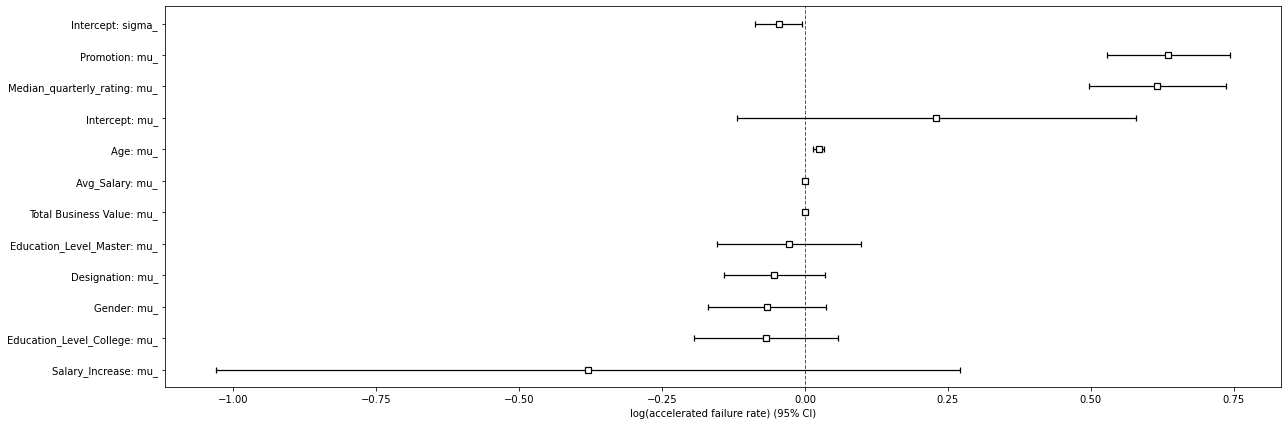

In [32]:
from lifelines import LogNormalAFTFitter

lnf = LogNormalAFTFitter()
lnf.fit(train_df_v2, 'time', 'event')

lnf.print_summary()

plt.figure(figsize = (20,7))
lnf.plot();

In [33]:
# checking model peformance metric
metric_lnf = \
pd.DataFrame({
    "model_name": "Log Normal Accerlated Failure time",
    "train_log_likelihood": lnf.log_likelihood_ ,
    "train_concordance_index":lnf.score(train_df_v2, scoring_method="concordance_index"),
    "val_log_likelihood":lnf.score(val_df_v2),
    "val_concordance_index":lnf.score(val_df_v2, scoring_method="concordance_index"),
    }, index = [3])

metric_all = metric_all.append(metric_lnf)

### Comparing various parametric and semi parametric model performance metrics

In [34]:
metric_all

,model_name,train_log_likelihood,train_concordance_index,val_log_likelihood,val_concordance_index
0,Cox Proptional Hazard,"-6,856.78",0.83,-3.47,0.84
1,Weibull Accerlated Failure time,"-3,783.97",0.83,-2.27,0.85
2,Log Logistic Accerlated Failure time,"-3,784.25",0.83,-2.25,0.83
3,Log Normal Accerlated Failure time,"-3,928.04",0.81,-2.34,0.82


### Generating predictions

In [38]:
# llf model output
output_df_llf = \
predict_survival(training_dataset, test, 
                 event_var = 'event', time_var = 'time', 
                 model = llf, period = 6, ID = "Emp_ID")

## saving output file
output_df_llf.to_csv("/content/drive/MyDrive/Data Science/survival_analysis/output/submission_llf.csv", 
                      index = False)